In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from scipy.stats import describe
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import seaborn as sns
from upsetplot import UpSet

In [26]:
#uncomment to get package versions used in notebook
#pip list

### Info on Data sources

#### ercc spike-ins

The ERCC spike-in control is a mixture of 92 synthetic polyadenylated oligonucleotides of 250-2000 nucleotides long that are meant to resemble human transcripts.

#### 1. human cell dataset with ercc spike-ins

SEQC benchmark data set and data from ENCODE project

The Sequencing Quality Control Consortium generated two datasets from two reference RNA samples in order to evaluate transcriptome profiling by next-generation sequencing technology. Each sample contains one of the reference RNA source and a set of synthetic RNAs from the External RNA Control Consortium (ERCC) at known concentrations.

Group A contains 5 replicates of the Strategene Universal Human Reference RNA (UHRR), which is composed of total RNA from 10 human cell lines, with 2% by volume of ERCC mix 1.

Group B includes 5 replicate samples of the Ambion Human Brain Reference RNA (HBRR) with 2% by volume of ERCC mix 2.

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49712

Rapaport F, Khanin R, Liang Y, Pirun M et al. Comprehensive evaluation of differential gene expression analysis methods for RNA-seq data. Genome Biol 2013;14(9):R95

#### 2. Arabidopsis dataset with ercc spike-ins

Arabidopsis embryos possess unique transcriptomes relative to other plant tissues including somatic embryos, and can be partitioned into four transcriptional phases with characteristic biological processes.

By comprehensively comparing embryonic and post-embryonic transcriptomes, we found that embryonic transcriptomes do not resemble any other plant tissue we analyzed. Moreover, transcriptome clustering analyses revealed the presence of four distinct phases of embryogenesis which are enriched in specific biological processes.

Two ERCC controls were used for the experiment: ERCC Mix 1 was used for flight samples and ERCC 2 was used for ground control samples. Briefly, 1 μl of 1:2000 diluted RNA spike-in ERCC (half the amount suggested in the ERCC user guide) spike to 50 ng of total RNA 

Falko Hofmann· Michael A. Schon· Michael D. Nodine. 2019: The embryonic transcriptome of Arabidopsis thaliana Plant Reproduction (2019) 32:77–91 https://doi.org/10.1007/s00497-018-00357-2

GSM4880354	WS Root, Flight, Blue Origin, replicate 1, ercc mix1

GSM4880355	WS Root, Flight, Blue Origin, replicate 2, ercc mix1

GSM4880356	WS Root, Flight, Blue Origin, replicate 3, ercc mix1

GSM4880357	WS Root, Ground Control, Blue Origin, replicate 1, ercc mix2

GSM4880358	WS Root, Ground Control, Blue Origin, replicate 2, ercc mix2

GSM4880359	WS Root, Ground Control, Blue Origin, replicate 3, ercc mix2

#### 3. Danio rerio dataset
Datasets:
https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA325275&o=acc_s%3Aa

Article:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5264326/

Reference genome and gff:
https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_other/Danio_rerio/latest_assembly_versions/GCF_000002035.6_GRCz11/

zebrafish grouped into either SBS surgery (n = 29, ercc mix2) or sham surgery (n = 28, ercc mix1) groups. 3 fish from each group were harvested for RNA sequencing at 2 weeks and the remaining fish were harvested for evaluation by histology or RT-qPCR. 

### Read and prepare dataframes

In [27]:
# paths to files
ercc_p = '../Data/ercc_spikedata.tsv'
# 1. human + ercc
hs_starsal_p = '../Data/deseq_hsdata/ssal_hs_DE.tsv'
hs_starrsem_p = '../Data/deseq_hsdata/srsem_hs_DE.tsv'
hs_starfc_p = '../Data/deseq_hsdata/sfc_hs_DE.tsv'
hs_hisatfc_p = '../Data/deseq_hsdata/hfc_hs_DE.tsv'
hs_pseudosal_p = '../Data/deseq_hsdata/psal_hs_DE.tsv'
# 2. arabidopsis + ercc
at_starsal_p = '../Data/deseq_tairdata/ssal_at_DE.tsv'
at_starrsem_p = '../Data/deseq_tairdata/srsem_at_DE.tsv'
at_starfc_p = '../Data/deseq_tairdata/sfc_at_DE.tsv'
at_hisatfc_p = '../Data/deseq_tairdata/hfc_at_DE.tsv'
at_pseudosal_p = '../Data/deseq_tairdata/psal_at_DE.tsv'
# 3. zebrafish (danio rerio) + ercc
dr_starsal_p = '../Data/deseq_daniodata/ssal_danio_DE.tsv'
dr_starrsem_p = '../Data/deseq_daniodata/srsem_danio_DE.tsv'
dr_starfc_p = '../Data/deseq_daniodata/sfc_danio_DE.tsv'
dr_hisatfc_p = '../Data/deseq_daniodata/hfc_danio_DE.tsv'
dr_pseudosal_p = '../Data/deseq_daniodata/psal_danio_DE.tsv'

In [28]:
# read to df
ercc_df = pd.read_csv(ercc_p, sep='\t').rename(columns={'ERCC ID':'gene_id'})
ercc_df['log2fc'] = np.log2(1/ercc_df['expected fold-change ratio'])
ercc_ids = ercc_df['gene_id'].sort_values().tolist()
# 1. human + ercc
hs_starsal_df = pd.read_csv(hs_starsal_p, sep='\t')
hs_starrsem_df = pd.read_csv(hs_starrsem_p, sep='\t')
hs_starfc_df = pd.read_csv(hs_starfc_p, sep='\t')
hs_hisatfc_df = pd.read_csv(hs_hisatfc_p, sep='\t')
hs_pseudosal_df = pd.read_csv(hs_pseudosal_p, sep='\t')
# 2. Arabidopsis + ercc
at_starsal_df = pd.read_csv(at_starsal_p, sep='\t')
at_starrsem_df = pd.read_csv(at_starrsem_p, sep='\t')
at_starfc_df = pd.read_csv(at_starfc_p, sep='\t')
at_hisatfc_df = pd.read_csv(at_hisatfc_p, sep='\t')
at_pseudosal_df = pd.read_csv(at_pseudosal_p, sep='\t')
# 3. Danio rerio + ercc
dr_starsal_df = pd.read_csv(dr_starsal_p, sep='\t')
dr_starrsem_df = pd.read_csv(dr_starrsem_p, sep='\t')
dr_starfc_df = pd.read_csv(dr_starfc_p, sep='\t')
dr_hisatfc_df = pd.read_csv(dr_hisatfc_p, sep='\t')
dr_pseudosal_df = pd.read_csv(dr_pseudosal_p, sep='\t')

In [29]:
# define column names for homo sapiens data
hs_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_treatment_B_vs_A':'log2fc',
           'lfcSE_condition_treatment_B_vs_A':'lfcSE',
           'stat_condition_treatment_B_vs_A':'stat',
           'pvalue_condition_treatment_B_vs_A':'pvalue',
           'padj_condition_treatment_B_vs_A':'padj'}

In [30]:
# define column names for arabidopsis thaliana data
at_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_stage_mix2_vs_mix1':'log2fc',
           'lfcSE_condition_stage_mix2_vs_mix1':'lfcSE',
           'stat_condition_stage_mix2_vs_mix1':'stat',
           'pvalue_condition_stage_mix2_vs_mix1':'pvalue',
           'padj_condition_stage_mix2_vs_mix1':'padj'}

In [31]:
# define column names for danio_rerio data
dr_coldict = {'Ensembl_ID':'gene_id',
           'log2FoldChange_condition_stage_sham_vs_sbs':'log2fc',
           'lfcSE_condition_stage_sham_vs_sbs':'lfcSE',
           'stat_condition_stage_sham_vs_sbs':'stat',
           'pvalue_condition_stage_sham_vs_sbs':'pvalue',
           'padj_condition_stage_sham_vs_sbs':'padj'}

In [32]:
# rename columns
hs_starsal = hs_starsal_df.rename(columns = hs_coldict)
hs_starrsem = hs_starrsem_df.rename(columns = hs_coldict)
hs_starfc = hs_starfc_df.rename(columns = hs_coldict)
hs_hisatfc = hs_hisatfc_df.rename(columns = hs_coldict)
hs_pseudosal = hs_pseudosal_df.rename(columns = hs_coldict)

at_starsal = at_starsal_df.rename(columns = at_coldict)
at_starrsem = at_starrsem_df.rename(columns = at_coldict)
at_starfc = at_starfc_df.rename(columns = at_coldict)
at_hisatfc = at_hisatfc_df.rename(columns = at_coldict)
at_pseudosal = at_pseudosal_df.rename(columns = at_coldict)

dr_starsal = dr_starsal_df.rename(columns = dr_coldict)
dr_starrsem = dr_starrsem_df.rename(columns = dr_coldict)
dr_starfc = dr_starfc_df.rename(columns = dr_coldict)
dr_hisatfc = dr_hisatfc_df.rename(columns = dr_coldict)
dr_pseudosal = dr_pseudosal_df.rename(columns = dr_coldict)

In [33]:
# featurecounts Danio table: gene_name - replace NaN by gene_id
dr_starfc['gene_name'] = dr_starfc['gene_id']
dr_hisatfc['gene_name'] = dr_hisatfc['gene_id']

In [34]:
# Salmon Arabidopsis table: strip "transcript:" from gene_id
at_starsal['gene_id'] = at_starsal['gene_id'].str.replace('transcript:', '')
at_pseudosal['gene_id'] = at_pseudosal['gene_id'].str.replace('transcript:', '')

In [35]:
# merge to one df
hs_df_all = hs_starsal.merge(hs_starrsem.merge(hs_starfc.merge(hs_hisatfc.merge(hs_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)

at_df_all = at_starsal.merge(at_starrsem.merge(at_starfc.merge(at_hisatfc.merge(at_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)

dr_df_all = dr_starsal.merge(dr_starrsem.merge(dr_starfc.merge(dr_hisatfc.merge(dr_pseudosal, on='gene_id', suffixes=('','_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('_ssal', '_srsem'))\
                .rename(columns = {'gene_name_ssal':'gene_name'})\
                .drop(['gene_name_srsem', 'gene_name_sfc', 'gene_name_hfc', 'gene_name_psal'], axis=1)


In [36]:
# Control df shape
print(hs_starsal.shape[0],hs_starrsem.shape[0], hs_starfc.shape[0], hs_hisatfc.shape[0], hs_pseudosal.shape[0], hs_df_all.shape[0] )
print(at_starsal.shape[0],at_starrsem.shape[0], at_starfc.shape[0], at_hisatfc.shape[0], at_pseudosal.shape[0],at_df_all.shape[0] )
print(dr_starsal.shape[0],dr_starrsem.shape[0], dr_starfc.shape[0], dr_hisatfc.shape[0], dr_pseudosal.shape[0],dr_df_all.shape[0] )

57865 57865 48679 48340 57427 47855
33694 33694 24624 24297 33119 24121
41605 47140 29328 30655 34914 23357


### Get gene length and number of exons from gtf file

Extraction from gtf file with GTFtool: http://www.genemine.org/gtftools.php

Calculate gene lengths. Since a gene may have multiple isoforms, there are multiple ways to calculate gene length based on literature. Three simple ways are considering the mean, median and maximum of the lengths of isoforms as the length of the gene. A fourth way is to calculate the length of merged exons of all isoforms (i.e. non-overlapping exonic length). So, in total, four different types of gene lengths(the mean, median and max of lengths of isoforms of agene, and the length of merged exons of isoforms of a gene) are provided.

Gene length command: 

``python3 gtftools.py  -l ../genes.gtf.genelength  ../genes.gtf``

For each gene, calculate merged exons by merging exons of all splice isoforms from the same gene. The output is merged exons in bed format. Used to calculate nonverlapping exonic length of genes with multiple splice isoforms.

No of exons command:

``python3 gtftools.py  -m ../genes.gtf.merged_exons.bed  ../genes.gtf``

In [37]:
# path to files:
hs_genelength_p = '../Data/deseq_hsdata/genes.gtf.genelength'
hs_exons_p = '../Data/deseq_hsdata/genes.gtf.merged_exons.bed'
at_genelength_p = '../Data/deseq_tairdata/tair.gtf.genelength'
at_exons_p = '../Data/deseq_tairdata/tair.gtf.merged_exons.bed'
dr_genelength_p = '../Data/deseq_daniodata/GRCz11.gtf.genelength'
dr_exons_p = '../Data/deseq_daniodata/GRCz11.gtf.merged_exons.bed'


In [38]:
# read gene length data to df
hs_genelength = pd.read_csv(hs_genelength_p, sep='\t', low_memory=False)
hs_genelength = hs_genelength.rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})
at_genelength = pd.read_csv(at_genelength_p, sep='\t', low_memory=False)
at_genelength = at_genelength.rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})
dr_genelength = pd.read_csv(dr_genelength_p, sep='\t', low_memory=False)
dr_genelength = dr_genelength.rename(columns={'gene_length':'length_mean'}).rename(columns={'gene':'gene_id', 'mean':'length_mean', 'median':'length_median', 'merged':'length_merged'})

In [39]:
# read exon counts to df
hs_exons_raw = pd.read_csv(hs_exons_p, sep='\t', low_memory=False, header=None)
hs_exons = pd.DataFrame(hs_exons_raw[3].value_counts())
hs_exons = hs_exons.reset_index().rename(columns={'index':'gene_id', 3:'exons'})
at_exons_raw = pd.read_csv(at_exons_p, sep='\t', low_memory=False, header=None)
at_exons = pd.DataFrame(at_exons_raw[3].value_counts())
at_exons = at_exons.reset_index().rename(columns={'index':'gene_id', 3:'exons'})
dr_exons_raw = pd.read_csv(dr_exons_p, sep='\t', low_memory=False, header=None)
dr_exons = pd.DataFrame(dr_exons_raw[5].value_counts())
dr_exons = dr_exons.reset_index().rename(columns={'index':'gene_id', 5:'exons'})

In [40]:
#dr_df_all: gene_name and gene_id are equal (i.e a1cf)
# extract gene_name from GRCz11.gtf
dr_idname_p = '../Data/danio_gene_idname.tsv'
dr_idname = pd.read_csv(dr_idname_p, sep='\t')
#df['col'] = df['col'].str[:9]
dr_idname['genename'] = dr_idname['gene_name'].str[2:-2]
dr_idname = dr_idname.drop('gene_name', axis=1).rename(columns={'genename':'gene_name'})

In [41]:
dr_exons_idname = dr_exons.merge(dr_idname, on='gene_id', how='left')
dr_length_idname = dr_genelength.merge(dr_idname, on='gene_id', how='left')

In [42]:
#append ercc length
ercc_l_p = "../Data/ercc_genelength.txt"
ercc_length = pd.read_csv(ercc_l_p, sep='\t', header=None).rename(columns={0:'gene_id', 1:'length_mean'})
ercc_length['length_median'] = ercc_length['length_mean']
ercc_length['longest_isoform'] = ercc_length['length_mean']
ercc_length['length_merged'] = ercc_length['length_mean']
hs_genelength = hs_genelength.append(ercc_length)
at_genelength = at_genelength.append(ercc_length)
#dr_genelength = dr_genelength.append(ercc_length)
dr_genelength = dr_length_idname.append(ercc_length)

In [43]:
dr_genelength['gene_name'].fillna(dr_genelength['gene_id'], inplace=True)

In [44]:
# create and append dummy exon df for ercc reads
ercc_exons = pd.DataFrame(ercc_df['gene_id'])
ercc_exons['exons'] = 0

hs_exons = hs_exons.append(ercc_exons)
at_exons = at_exons.append(ercc_exons)
ercc_exons['gene_name'] = ercc_exons['gene_id']
dr_exons = dr_exons_idname.append(ercc_exons)

hs_l_ex = hs_genelength.merge(hs_exons, on='gene_id')
at_l_ex = at_genelength.merge(at_exons, on='gene_id')
dr_l_ex = dr_genelength.merge(dr_exons, on='gene_id')

In [45]:
# dr dataframe replace ERCC gene_names with gene_id
dr_df_all['gene_name'] = np.where(dr_df_all['gene_id'].str.contains('ERCC-0'), dr_df_all['gene_id'], dr_df_all['gene_name'])

In [46]:
# merge gene length and exon number into df_all
print('hs:')
print(hs_df_all.shape)
hs_df_all = hs_df_all.merge(hs_genelength, on='gene_id', how='left')
print(hs_df_all.shape)
hs_df_all = hs_df_all.merge(hs_exons, on='gene_id', how='left')
print(hs_df_all.shape)
print('at:')
print(at_df_all.shape)
at_df_all = at_df_all.merge(at_genelength, on='gene_id', how='left')
print(at_df_all.shape)
at_df_all = at_df_all.merge(at_exons, on='gene_id', how='left')
print(at_df_all.shape)
print('dr:')
print(dr_df_all.shape)
dr_df_all = dr_df_all.merge(dr_genelength, on=['gene_name'], how='left')
#print(dr_df_all.shape)
dr_df_all = dr_df_all.drop('gene_id_x', axis=1).rename(columns={'gene_id_y':'gene_id'})
print(dr_df_all.shape)
dr_df_all = dr_df_all.merge(dr_exons, on='gene_id', how='left')
#print(dr_df_test3.shape)
dr_df_all = dr_df_all.drop('gene_name_y', axis=1).rename(columns={'gene_name_x':'gene_name'})
print(dr_df_all.shape)
#print(dr_df_all.shape)

hs:
(47855, 42)
(47855, 46)
(47855, 47)
at:
(24121, 42)
(24121, 46)
(24121, 47)
dr:
(23357, 42)
(23578, 46)
(23578, 47)


In [47]:
# save merged dataframes
hs_df_all.to_csv('../Data/hs_df_all.tsv', sep='\t', index=None)
at_df_all.to_csv('../Data/at_df_all.tsv', sep='\t', index=None)
dr_df_all.to_csv('../Data/dr_df_all.tsv', sep='\t', index=None)

In [48]:
def plot_hist(df_in, col, b, m, c, l):
    num = int(df_in[col].max()/b)
    df = df_in[df_in['exons']>m]
    plt.hist(df[col], bins=num, log=True, color=c, label=l)

In [49]:
print('Total number of genes: \n hs: {} \n at: {} \n dr: {}'.format(hs_exons.shape[0], at_exons.shape[0], dr_exons.shape[0]))
print('Maximum number of exons: \n hs: {} \n at: {} \n dr: {}'.format(hs_exons['exons'].max(), at_exons['exons'].max(), dr_exons['exons'].max()))
print('Number of genes without exons: \n hs: {} \n at: {} \n dr: {}'.format(hs_exons[hs_exons['exons']<1].shape[0], at_exons[at_exons['exons']<1].shape[0], dr_exons[dr_exons['exons']<1].shape[0]))
print('Number of genes with one exon: \n hs: {} ({:.3}) \n at: {} ({:.3}) \n dr: {} ({:.3})'.format(hs_exons[hs_exons['exons']<2].shape[0],hs_exons[hs_exons['exons']<2].shape[0]/hs_exons.shape[0], at_exons[at_exons['exons']<2].shape[0], at_exons[at_exons['exons']<2].shape[0]/at_exons.shape[0], dr_exons[dr_exons['exons']<2].shape[0], dr_exons[dr_exons['exons']<2].shape[0]/dr_exons.shape[0]))
print('Number of genes up to 5 exons: \n hs: {} ({:.3}) \n at: {} ({:.3}) \n dr: {} ({:.3})'.format(hs_exons[hs_exons['exons']<6].shape[0],hs_exons[hs_exons['exons']<6].shape[0]/hs_exons.shape[0], at_exons[at_exons['exons']<6].shape[0], at_exons[at_exons['exons']<6].shape[0]/at_exons.shape[0], dr_exons[dr_exons['exons']<6].shape[0], dr_exons[dr_exons['exons']<6].shape[0]/dr_exons.shape[0]))
print('Number of genes up to 10 exons: \n hs: {} ({:.3}) \n at: {} ({:.3}) \n dr: {} ({:.3})'.format(hs_exons[hs_exons['exons']<11].shape[0],hs_exons[hs_exons['exons']<11].shape[0]/hs_exons.shape[0], at_exons[at_exons['exons']<11].shape[0], at_exons[at_exons['exons']<11].shape[0]/at_exons.shape[0], dr_exons[dr_exons['exons']<11].shape[0], dr_exons[dr_exons['exons']<11].shape[0]/dr_exons.shape[0]))
print('Number of genes >10 exons: \n hs: {} ({:.3}) \n at: {} ({:.3}) \n dr: {} ({:.3})'.format(hs_exons[hs_exons['exons']>10].shape[0],hs_exons[hs_exons['exons']>10].shape[0]/hs_exons.shape[0], at_exons[at_exons['exons']>10].shape[0], at_exons[at_exons['exons']>10].shape[0]/at_exons.shape[0], dr_exons[dr_exons['exons']>10].shape[0], dr_exons[dr_exons['exons']>10].shape[0]/dr_exons.shape[0]))


Total number of genes: 
 hs: 57828 
 at: 34032 
 dr: 29172
Maximum number of exons: 
 hs: 367 
 at: 77 
 dr: 590
Number of genes without exons: 
 hs: 92 
 at: 92 
 dr: 92
Number of genes with one exon: 
 hs: 22876 (0.396) 
 at: 11581 (0.34) 
 dr: 4088 (0.14)
Number of genes up to 5 exons: 
 hs: 41299 (0.714) 
 at: 24889 (0.731) 
 dr: 12110 (0.415)
Number of genes up to 10 exons: 
 hs: 48454 (0.838) 
 at: 30677 (0.901) 
 dr: 17383 (0.596)
Number of genes >10 exons: 
 hs: 9374 (0.162) 
 at: 3355 (0.0986) 
 dr: 11789 (0.404)


In [50]:
hs_excounts = pd.DataFrame(hs_exons['exons'].value_counts()).reset_index().rename(columns={'index':'no_exons', 'exons':'hsapiens'})
at_excounts = pd.DataFrame(at_exons['exons'].value_counts()).reset_index().rename(columns={'index':'no_exons', 'exons':'athaliana'})
dr_excounts = pd.DataFrame(dr_exons['exons'].value_counts()).reset_index().rename(columns={'index':'no_exons', 'exons':'drerio'})
#exon_counts = pd.DataFrame(hs_excounts).reset_index().rename(columns={'index':'no_exons', 'exons':'hsapiens'})
exon_counts = hs_excounts.merge(at_excounts.merge(dr_excounts, on='no_exons', how='outer'), on='no_exons', how='outer').fillna(-1)
exon_counts.sort_values('no_exons', inplace=True)


([<matplotlib.axis.XTick at 0x7fcd0d6722b0>,
 [Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7'),
  Text(8.0, 0, '8'),
  Text(9.0, 0, '9'),
  Text(10.0, 0, '10'),
  Text(11.0, 0, '11'),
  Text(12.0, 0, '12'),
  Text(13.0, 0, '13'),
  Text(14.0, 0, '14'),
  Text(15.0, 0, '15'),
  Text(16.0, 0, '16'),
  Text(17.0, 0, '17'),
  Text(18.0, 0, '18'),
  Text(19.0, 0, '19')])

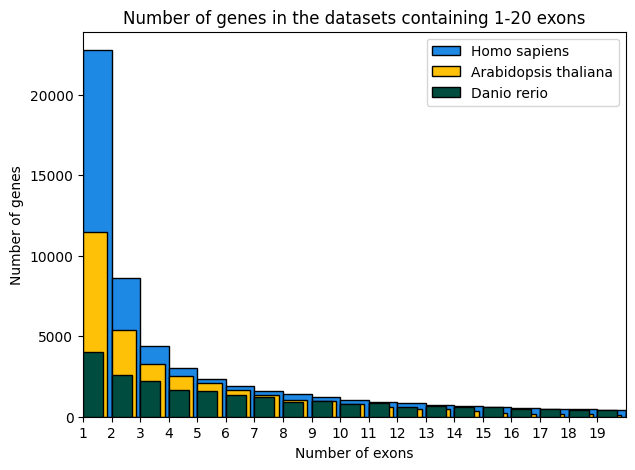

In [51]:
#bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)[source]#
#fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(7,5))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.bar('no_exons','hsapiens', data=hs_excounts, width=1, color='#1E88E5', label='Homo sapiens', edgecolor='black', align='edge')
ax.bar('no_exons','athaliana', data=at_excounts, width=0.85, color='#FFC107', label='Arabidopsis thaliana', edgecolor='black', align='edge' )
ax.bar('no_exons','drerio', data=dr_excounts, width=0.7, color='#004D40', label='Danio rerio', edgecolor='black', align='edge' )
#ax.set_xlim(l,m)
ax.set_xlim(1,20)
ax.legend()
plt.title('Number of genes in the datasets containing 1-20 exons')
plt.xlabel('Number of exons')
plt.ylabel('Number of genes')
plt.xticks(np.arange(1, 20, 1.0))



In [52]:
# fill NA in col 'contrast_vector' with 0
hs_df_all['contrast_vector_ssal'] = hs_df_all['contrast_vector_ssal'].fillna(0).astype(int)
hs_df_all['contrast_vector_srsem'] = hs_df_all['contrast_vector_srsem'].fillna(0).astype(int)
hs_df_all['contrast_vector_psal'] = hs_df_all['contrast_vector_psal'].fillna(0).astype(int)
at_df_all['contrast_vector_ssal'] = at_df_all['contrast_vector_ssal'].fillna(0).astype(int)
at_df_all['contrast_vector_srsem'] = at_df_all['contrast_vector_srsem'].fillna(0).astype(int)
at_df_all['contrast_vector_psal'] = at_df_all['contrast_vector_psal'].fillna(0).astype(int)
dr_df_all['contrast_vector_ssal'] = dr_df_all['contrast_vector_ssal'].fillna(0).astype(int)
dr_df_all['contrast_vector_srsem'] = dr_df_all['contrast_vector_srsem'].fillna(0).astype(int)
dr_df_all['contrast_vector_psal'] = dr_df_all['contrast_vector_psal'].fillna(0).astype(int)

In [53]:
# how many genes have missing length or exon values?
print('HS: genes missing length nums: ',hs_df_all['length_merged'].isna().sum())
print('HS: genes missing exon nums: ',hs_df_all['exons'].isna().sum())
print('HS gene_lenght min/max', hs_df_all['length_merged'].min(), hs_df_all['length_merged'].max())
print('HS exon num min/max', hs_df_all['exons'].min(), hs_df_all['exons'].max())
print('')
print('AT: genes missing length nums: ',at_df_all['length_merged'].isna().sum())
print('AT: genes missing exon nums: ',at_df_all['exons'].isna().sum())
print('AT gene_lenght min/max', at_df_all['length_merged'].min(), at_df_all['length_merged'].max())
print('AT exon num min/max', at_df_all['exons'].min(), at_df_all['exons'].max())
print('')
print('DR: genes missing length nums: ',dr_df_all['length_mean'].isna().sum())
print('DR: genes missing exon nums: ',dr_df_all['exons'].isna().sum())
print('DR gene_lenght min/max', dr_df_all['length_mean'].min(), dr_df_all['length_mean'].max())
print('DR exon num min/max', dr_df_all['exons'].min(), dr_df_all['exons'].max())

HS: genes missing length nums:  37
HS: genes missing exon nums:  37
HS gene_lenght min/max 21.0 118327.0
HS exon num min/max 0.0 367.0

AT: genes missing length nums:  973
AT: genes missing exon nums:  973
AT gene_lenght min/max 69.0 16614.0
AT exon num min/max 0.0 77.0

DR: genes missing length nums:  9067
DR: genes missing exon nums:  9067
DR gene_lenght min/max 99.0 20569.0
DR exon num min/max 0.0 590.0


### Number of isoforms per gene

In [54]:
# number of isoforms
hs_isoforms_p = '../Data/deseq_hsdata/genes.gtf_isoforms.bed'
at_isoforms_p = '../Data/deseq_tairdata/tair.gtf_isoforms.bed.tsv'
dr_isoforms_p = '../Data/deseq_daniodata/danio_ercc_isoform.bed'

In [55]:
hs_isoforms_raw = pd.read_csv(hs_isoforms_p, sep='\t')
hs_isoforms = pd.DataFrame(hs_isoforms_raw['gene'].value_counts())
hs_isoforms = hs_isoforms.reset_index().rename(columns={'index':'gene_id', 'gene':'isoforms'})

at_isoforms_raw = pd.read_csv(at_isoforms_p, sep='\t')
at_isoforms = pd.DataFrame(at_isoforms_raw['gene'].value_counts())
at_isoforms = at_isoforms.reset_index().rename(columns={'index':'gene_id', 'gene':'isoforms'})

dr_isoforms_raw = pd.read_csv(dr_isoforms_p, sep='\t')
dr_isoforms = pd.DataFrame(dr_isoforms_raw['gene'].value_counts())
dr_isoforms = dr_isoforms.reset_index().rename(columns={'index':'gene_id', 'gene':'isoforms'})

In [56]:
#merge number of isoforms to complete dataframe df_all
hs_df_all = hs_df_all.merge(hs_isoforms, on='gene_id', how='left')
at_df_all = at_df_all.merge(at_isoforms, on='gene_id', how='left')
dr_df_all = dr_df_all.merge(dr_isoforms, on='gene_id', how='left')


In [57]:
hs_isocounts = pd.DataFrame(hs_isoforms['isoforms'].value_counts()).reset_index().rename(columns={'index':'no_isoforms', 'isoforms':'hsapiens'})
at_isocounts = pd.DataFrame(at_isoforms['isoforms'].value_counts()).reset_index().rename(columns={'index':'no_isoforms', 'isoforms':'athaliana'})
dr_isocounts = pd.DataFrame(dr_isoforms['isoforms'].value_counts()).reset_index().rename(columns={'index':'no_isoforms', 'isoforms':'drerio'})

Text(0, 0.5, 'Number of genes')

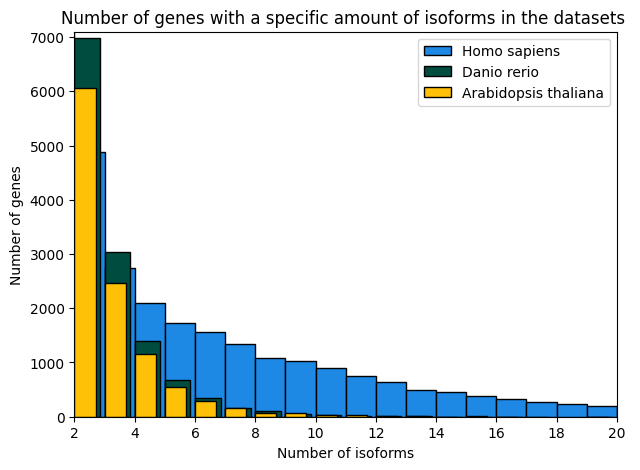

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax.bar('no_isoforms','hsapiens', data=hs_isocounts, width=1, color='#1E88E5', label='Homo sapiens', edgecolor='black', align='edge')
ax.bar('no_isoforms','drerio', data=dr_isocounts, width=0.85, color='#004D40', label='Danio rerio', edgecolor='black', align='edge' )
ax.bar('no_isoforms','athaliana', data=at_isocounts, width=0.7, color='#FFC107', label='Arabidopsis thaliana', edgecolor='black', align='edge' )
#ax.set_xlim(l,m)
ax.set_xlim(2,20)
ax.set_ylim(0,7100)
ax.legend()
plt.title('Number of genes with a specific amount of isoforms in the datasets ')
plt.xlabel('Number of isoforms')
plt.ylabel('Number of genes')
#plt.xticks(np.arange(1, 20, 1.0))

In [59]:
print(' hs')
hs_all = hs_isocounts['hsapiens'].sum()
hs_val1 = hs_isocounts.loc[hs_isocounts['no_isoforms']==1,'hsapiens'].iloc[0]
hs_val2 = hs_isocounts.loc[hs_isocounts['no_isoforms']==2,'hsapiens'].iloc[0]
hs_above5 = hs_isocounts.loc[hs_isocounts['no_isoforms']>5,'hsapiens'].iloc[0]
hs_max = hs_isocounts['no_isoforms'].max()
print('Nof genes with one transcript (%): {} ({:.3}%)'.format(hs_val1, hs_val1*100/hs_all))
print('Nof genes with two transcripts (%): {} ({:.3}%)'.format(hs_val2, hs_val2*100/hs_all))
print('Nof genes with >5 transcripts (%): {} ({:.3}%)'.format(hs_above5, hs_above5*100/hs_all))
print('Max number of isoforms per gene: {}, occurring in {} gene/s'.format(hs_max, hs_isocounts.loc[hs_isocounts['no_isoforms']==hs_max, 'hsapiens'].iloc[0]))

print('\n at')
at_all = at_isocounts['athaliana'].sum()
at_val1 = at_isocounts.loc[at_isocounts['no_isoforms']==1,'athaliana'].iloc[0]
at_val2 = at_isocounts.loc[at_isocounts['no_isoforms']==2,'athaliana'].iloc[0]
at_above5 = at_isocounts.loc[at_isocounts['no_isoforms']>5,'athaliana'].iloc[0]
at_max = at_isocounts['no_isoforms'].max()
print('Nof genes with one transcript (%): {} ({:.3}%)'.format(at_val1, at_val1*100/at_all))
print('Nof genes with two transcripts (%): {} ({:.3}%)'.format(at_val2, at_val2*100/at_all))
print('Nof genes with >5 transcripts (%): {} ({:.3}%)'.format(at_above5, at_above5*100/at_all))
print('Max number of isoforms per gene: {}, occurring in {} gene/s'.format(at_max, at_isocounts.loc[at_isocounts['no_isoforms']==at_max, 'athaliana'].iloc[0]))

print('\n dr')
dr_all = dr_isocounts['drerio'].sum()
dr_val1 = dr_isocounts.loc[dr_isocounts['no_isoforms']==1,'drerio'].iloc[0]
dr_val2 = dr_isocounts.loc[dr_isocounts['no_isoforms']==2,'drerio'].iloc[0]
dr_above5 = dr_isocounts.loc[dr_isocounts['no_isoforms']>5,'drerio'].iloc[0]
dr_max = dr_isocounts['no_isoforms'].max()
print('Nof genes with one transcript (%): {} ({:.3}%)'.format(dr_val1, dr_val1*100/dr_all))
print('Nof genes with two transcripts (%): {} ({:.3}%)'.format(dr_val2, dr_val2*100/dr_all))
print('Nof genes with >5 (%): {} ({:.3}%)'.format(dr_above5, dr_above5*100/dr_all))
print('Max number of isoforms per gene: {}, occurring in {} gene/s'.format(dr_max, dr_isocounts.loc[dr_isocounts['no_isoforms']==dr_max, 'drerio'].iloc[0]))


 hs
Nof genes with one transcript (%): 35553 (61.6%)
Nof genes with two transcripts (%): 4877 (8.45%)
Nof genes with >5 transcripts (%): 1560 (2.7%)
Max number of isoforms per gene: 82, occurring in 1 gene/s

 at
Nof genes with one transcript (%): 23025 (67.8%)
Nof genes with two transcripts (%): 6061 (17.9%)
Nof genes with >5 transcripts (%): 297 (0.875%)
Max number of isoforms per gene: 27, occurring in 1 gene/s

 dr
Nof genes with one transcript (%): 16223 (55.8%)
Nof genes with two transcripts (%): 6985 (24.0%)
Nof genes with >5 (%): 352 (1.21%)
Max number of isoforms per gene: 20, occurring in 1 gene/s


### Count common and diverging DE genes between pipelines

In [60]:
# join info on DE(1)/not_DE(0) of all pipeline runs
hs_df_all['compareDE'] = hs_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+hs_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+hs_df_all['contrast_vector_sfc'].astype(str)+hs_df_all['contrast_vector_hfc'].astype(str)+hs_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)
at_df_all['compareDE'] = at_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+at_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+at_df_all['contrast_vector_sfc'].astype(str)+at_df_all['contrast_vector_hfc'].astype(str)+at_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)
dr_df_all['compareDE'] = dr_df_all['contrast_vector_ssal'].fillna(0).astype(int).astype(str)+dr_df_all['contrast_vector_srsem'].fillna(0).astype(int).astype(str)+dr_df_all['contrast_vector_sfc'].astype(str)+dr_df_all['contrast_vector_hfc'].astype(str)+dr_df_all['contrast_vector_psal'].fillna(0).astype(int).astype(str)


In [61]:
hs_df_all.columns

Index(['gene_name', 'gene_id', 'baseMean_ssal', 'log2fc_ssal', 'lfcSE_ssal',
       'stat_ssal', 'pvalue_ssal', 'padj_ssal', 'contrast_vector_ssal',
       'outcome_ssal', 'baseMean_srsem', 'log2fc_srsem', 'lfcSE_srsem',
       'stat_srsem', 'pvalue_srsem', 'padj_srsem', 'contrast_vector_srsem',
       'outcome_srsem', 'baseMean_sfc', 'log2fc_sfc', 'lfcSE_sfc', 'stat_sfc',
       'pvalue_sfc', 'padj_sfc', 'contrast_vector_sfc', 'outcome_sfc',
       'baseMean_hfc', 'log2fc_hfc', 'lfcSE_hfc', 'stat_hfc', 'pvalue_hfc',
       'padj_hfc', 'contrast_vector_hfc', 'outcome_hfc', 'baseMean_psal',
       'log2fc_psal', 'lfcSE_psal', 'stat_psal', 'pvalue_psal', 'padj_psal',
       'contrast_vector_psal', 'outcome_psal', 'length_mean', 'length_median',
       'longest_isoform', 'length_merged', 'exons', 'isoforms', 'compareDE'],
      dtype='object')

In [62]:
# Count DE occurrences over pipelines
# e.g. compare(hs_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_human', '_ercc')
def compare(df, filtercol, compcol, filterids, suf1, suf2, suf3):
    df_no = df[~df[filtercol].isin(filterids)]
    df_ids = df[df[filtercol].isin(filterids)]
    compare_no = pd.DataFrame(df_no[compcol].value_counts())
    compare_no = compare_no.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    compare_ids = pd.DataFrame(df_ids[compcol].value_counts())
    compare_ids = compare_ids.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    compare_all = pd.DataFrame(df[compcol].value_counts())
    compare_all = compare_all.reset_index().rename(columns={'index':'DEcombi', compcol:'count'})
    # merge
    compare = compare_all.merge(compare_no.merge(compare_ids, on='DEcombi', suffixes=('', suf3), how='left'), on='DEcombi', suffixes=(suf1, suf2)).fillna(0)
    return compare

In [63]:
hs_compare = compare(hs_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_human', '_ercc')
at_compare = compare(at_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_tair', '_ercc')
dr_compare = compare(dr_df_all, 'gene_id', 'compareDE', ercc_ids, '_all', '_danio', '_ercc')

#### prepare Data for usage in R package VennDiagram

In [64]:
# prepare data for R package VennDiagram (5 groups, including pseudoSalmon)
area1lst5 = ( '00000','11111', '11001', '10111', '11011', '10001', '11101', '10101', '10011', '11110','11000', '10110', '11010', '10000', '11100', '10100', '10010')
area2lst5 = ( '00000','11111', '11001', '11011', '01001', '11101', '01111', '01101', '01011','11110','11000', '11010', '01000', '11100', '01110', '01100', '01010')
area3lst5 = ( '00000','11111', '10101', '10111', '00101', '11101', '01111', '01101', '00111','11110', '10100', '10110', '00100', '11100', '01110', '01100', '00110')
area4lst5 = ( '00000','11111', '10011', '11011', '00011', '10111', '01111', '00111', '01011','11110', '10010', '11010', '00010', '10110', '01110', '00110', '01010')
area5lst5 = ( '00000','11111', '00001', '10001', '01001', '00101', '00011', '11001', '10101', '10011', '01101', '01011', '00111', '11101', '11011', '10111', '01111')
n12lst5 = ( '00000','11111', '11001', '11011', '11101','11110', '11000', '11010', '11100')
n13lst5 = ( '00000','11111', '10111', '11101', '10101','11110', '10110', '11100', '10100')
n14lst5 = ( '00000','11111', '10111', '11011', '10011','11110', '10110', '11010', '10010')
n15lst5 = ( '00000','11111', '10001', '11001', '10101', '10011', '11101', '11011', '10111')
n23lst5 = ( '00000','11111', '11101', '01111', '01101','11110', '11100', '01110', '01100')
n24lst5 = ( '00000','11111', '11011', '01111', '01011','11110', '11010', '01110', '01010')
n25lst5 = ( '00000','11111', '01001', '11001', '01101', '01011', '11101', '11011', '01111')
n34lst5 = ( '00000','11111', '10111', '01111', '00111','11110', '10110', '01110', '00110')
n35lst5 = ( '00000','11111', '00101', '10101', '01101', '00111', '11101', '10111', '01111')
n45lst5 = ( '00000','11111', '00011', '10011', '01011', '00111', '10111', '11011', '01111')
n123lst5 = ( '00000','11111', '11101','11110', '11100')
n124lst5 = ( '00000','11111', '11011','11110', '11010')
n125lst5 = ( '00000','11111', '11001', '11101', '11011')
n134lst5 = ( '00000','11111', '10111','11110', '10110')
n135lst5 = ( '00000','11111', '10101', '11101', '10111')
n145lst5 = ( '00000','11111', '10011', '11011', '10111')
n234lst5 = ( '00000','11111', '01111','11110', '01110')
n235lst5 = ( '00000','11111', '01101', '11101', '01111')
n245lst5 = ( '00000','11111', '01011', '11011', '01111')
n345lst5 = ( '00000','11111', '00111', '10111', '01111')
n1234lst5 = ( '00000','11111', '11110')
n1235lst5 = ( '00000','11111', '11101')
n1245lst5 = ( '00000','11111', '11011')
n1345lst5 = ( '00000','11111', '10111')
n2345lst5 = ( '00000','11111', '01111')
n12345lst5 = ( '00000','11111')

In [65]:
def sumbinary(df, col, lst):
    sum = 0
    for i in lst:
        sum = sum+df.loc[df['DEcombi']==i, col].iloc[0]
    return sum

In [66]:
# print values for Venn Diagramm R script
def printVals5(compare, compcol):
    area1 = sumbinary(compare, compcol, area1lst5)
    area2 = sumbinary(compare, compcol, area2lst5)
    area3 = sumbinary(compare, compcol, area3lst5)
    area4 = sumbinary(compare, compcol, area4lst5)
    area5 = sumbinary(compare, compcol, area5lst5)
    print('area1={},\n area2={},\n area3={},\n area4={}, \n area5={},'.format(area1, area2, area3, area4, area5))
    n12 = sumbinary(compare, compcol, n12lst5) 
    n13 = sumbinary(compare, compcol, n13lst5)
    n14 = sumbinary(compare, compcol, n14lst5)
    n15 = sumbinary(compare, compcol, n15lst5)
    n23 = sumbinary(compare, compcol, n23lst5)
    n24 = sumbinary(compare, compcol, n24lst5)
    n25 = sumbinary(compare, compcol, n25lst5)
    n34 = sumbinary(compare, compcol, n34lst5)
    n35 = sumbinary(compare, compcol, n35lst5)
    n45 = sumbinary(compare, compcol, n45lst5)
    print('n12={},\n n13={},\n n14={},\n n15={},\n n23={},\n n24={},\n n25={},\n n34={},\n n35={},\n n45={},'.format(n12, n13, n14, n15, n23, n24, n25, n34, n35, n45,))
    n123 = sumbinary(compare, compcol, n123lst5)
    n124 = sumbinary(compare, compcol, n124lst5)
    n125 = sumbinary(compare, compcol, n125lst5)
    n134 = sumbinary(compare, compcol, n134lst5)
    n135 = sumbinary(compare, compcol, n135lst5)
    n145 = sumbinary(compare, compcol, n145lst5)
    n234 = sumbinary(compare, compcol, n234lst5)
    n235 = sumbinary(compare, compcol, n235lst5)
    n245 = sumbinary(compare, compcol, n245lst5)
    n345 = sumbinary(compare, compcol, n345lst5)
    print('n123={},\n n124={},\n n125={},\n n134={},\n n135={},\n n145={},\n n234={},\n n235={},\n n245={},\n n345={},'.format(n123, n124, n125, n134, n135, n145, n234, n235, n245, n345))
    n1234 = sumbinary(compare, compcol, n1234lst5)
    n1235 = sumbinary(compare, compcol, n1235lst5)
    n1245 = sumbinary(compare, compcol, n1245lst5)
    n1345 = sumbinary(compare, compcol, n1345lst5)
    n2345 = sumbinary(compare, compcol, n2345lst5)
    #n12345 = sumbinary(compare,compcol,n12345lst5)
    #print('n1234={},\n n1235={},\n n1245={},\n n1345={},\n n2345={},\n n12345={}'.format(n1234, n1235, n1245, n1345, n2345, n12345))
    print('n1234={},\n n1235={},\n n1245={},\n n1345={},\n n2345={},'.format(n1234, n1235, n1245, n1345, n2345))
    print('n12345={}'.format(compare.loc[compare['DEcombi']=='11111', compcol].iloc[0]+compare.loc[compare['DEcombi']=='00000', compcol].iloc[0]))
    #print('n12345={}'.format(n12345)
    print('notDE concordant = {}'.format(compare.loc[compare['DEcombi']=='00000', compcol].iloc[0]))

In [67]:
#Uncomment line to print values for R script VennDiagramm()

#printVals5(hs_compare, 'count_all')
#printVals5(hs_compare, 'count_ercc')
#printVals5(hs_compare, 'count_human')
#printVals5(at_compare, 'count_all')
#printVals5(at_compare, 'count_ercc')
#printVals5(at_compare, 'count_tair')
#printVals5(dr_compare, 'count_all')
printVals5(dr_compare, 'count_ercc')
#printVals5(dr_compare, 'count_danio')

area1=87.0,
 area2=88.0,
 area3=88.0,
 area4=87.0, 
 area5=87.0,
n12=87.0,
 n13=87.0,
 n14=87.0,
 n15=87.0,
 n23=87.0,
 n24=87.0,
 n25=87.0,
 n34=87.0,
 n35=87.0,
 n45=87.0,
n123=87.0,
 n124=87.0,
 n125=87.0,
 n134=87.0,
 n135=87.0,
 n145=87.0,
 n234=87.0,
 n235=87.0,
 n245=87.0,
 n345=87.0,
n1234=87.0,
 n1235=87.0,
 n1245=87.0,
 n1345=87.0,
 n2345=87.0,
n12345=87.0
notDE concordant = 40.0


In [68]:
def percent(x, y):
    return x*100/y
#hs
hs_DE_mean=(23033+22847+26744+27673+23545)/5
hs_DE_single = [113, 102, 336, 1134, 171]
hs_DE_single_pc = [percent(x, hs_DE_mean) for x in hs_DE_single]
hs_DE_common_pc = 20984*100/hs_DE_mean
print(f'hs: number DE genes (mean): {hs_DE_mean}')
print(f'hs: % common DE genes: {hs_DE_common_pc:.3}%')
print(f'hs: percentage single DE genes (%): \n \t ssal {hs_DE_single_pc[0]:.2}%, \n \t srsem {hs_DE_single_pc[1]:.2}%, \n \t sfc {hs_DE_single_pc[2]:.2}%, \n \t hfc {hs_DE_single_pc[3]:.2}%, \n \t psal {hs_DE_single_pc[4]:.2}%')    
print(f'hs: mean percentage single DE genes: {np.mean(hs_DE_single_pc):.2}%')

hs: number DE genes (mean): 24768.4
hs: % common DE genes: 84.7%
hs: percentage single DE genes (%): 
 	 ssal 0.46%, 
 	 srsem 0.41%, 
 	 sfc 1.4%, 
 	 hfc 4.6%, 
 	 psal 0.69%
hs: mean percentage single DE genes: 1.5%


In [69]:
#at
at_DE_mean=(4327+4102+4533+4452+4436)/5
at_DE_single = [53, 73, 93, 75, 71]
at_DE_single_pc = [percent(x, at_DE_mean) for x in at_DE_single]
at_DE_common_pc = 3712*100/at_DE_mean
print(f'at: number DE genes (mean): {at_DE_mean}')
print(f'at: % common DE genes: {at_DE_common_pc:.3}%')
print(f'at: percentage single DE genes (%): \n \t ssal {at_DE_single_pc[0]:.2}%, \n \t srsem {at_DE_single_pc[1]:.2}%, \n \t sfc {at_DE_single_pc[2]:.2}%, \n \t hfc {at_DE_single_pc[3]:.2}%, \n \t psal {at_DE_single_pc[4]:.2}%')    
print(f'at: mean percentage single DE genes: {np.mean(at_DE_single_pc):.2}%')

at: number DE genes (mean): 4370.0
at: % common DE genes: 84.9%
at: percentage single DE genes (%): 
 	 ssal 1.2%, 
 	 srsem 1.7%, 
 	 sfc 2.1%, 
 	 hfc 1.7%, 
 	 psal 1.6%
at: mean percentage single DE genes: 1.7%


In [70]:
#dr
dr_DE_mean=(8644+8197+8082+7934+8666)/5
dr_DE_single = [95, 165, 131, 102, 120]
dr_DE_single_pc = [percent(x, dr_DE_mean) for x in dr_DE_single]
dr_DE_common_pc = 6973*100/dr_DE_mean
print(f'dr: number DE genes (mean): {dr_DE_mean}')
print(f'dr: % common DE genes: {dr_DE_common_pc:.3}%')
print(f'dr: percentage single DE genes (%): \n \t ssal {dr_DE_single_pc[0]:.2}%, \n \t srsem {dr_DE_single_pc[1]:.2}%, \n \t sfc {dr_DE_single_pc[2]:.2}%, \n \t hfc {dr_DE_single_pc[3]:.2}%, \n \t psal {dr_DE_single_pc[4]:.2}%')    
print(f'dr: mean percentage single DE genes: {np.mean(dr_DE_single_pc):.2}%')

dr: number DE genes (mean): 8304.6
dr: % common DE genes: 84.0%
dr: percentage single DE genes (%): 
 	 ssal 1.1%, 
 	 srsem 2.0%, 
 	 sfc 1.6%, 
 	 hfc 1.2%, 
 	 psal 1.4%
dr: mean percentage single DE genes: 1.5%


In [71]:
meanDEcommon = np.mean([hs_DE_common_pc, at_DE_common_pc, dr_DE_common_pc])
stdDEcommon = np.std([hs_DE_common_pc, at_DE_common_pc, dr_DE_common_pc])
print('mean of {:.4} +/- {:.2} DE genes identified by all pipelines'.format(meanDEcommon, stdDEcommon))

mean of 84.54 +/- 0.42 DE genes identified by all pipelines


In [72]:
meanDEsingle = np.mean([hs_DE_single_pc, at_DE_single_pc, dr_DE_single_pc])
stdDEsingle = np.std([hs_DE_single_pc, at_DE_single_pc, dr_DE_single_pc])
print('mean of {:.3} +/- {:.2} DE genes identified by single pipelines'.format(meanDEsingle, stdDEsingle))

mean of 1.55 +/- 0.95 DE genes identified by single pipelines


In [73]:
rmse_hs_32= [0.517, 0.521, 0.675]
rmse_hs_142= 0.397
rmse_hs_in = [0.517, 0.521, 0.675, 0.397]
rmse_hs_vs = [0.982, 1.01, 1.04, 1.03, 0.931, 0.955]

rmse_at_32 = [0.398, 0.545, 0.565]
rmse_at_142 = 0.486
rmse_at_in = [0.398, 0.545, 0.565, 0.486]
rmse_at_vs = [0.985, 1.14, 1.01, 1.15, 0.945, 1.09]

rmse_dr_32 = [0.683, 0.388, 0.701]
rmse_dr_142 = 0.432
rmse_dr_in = [0.683, 0.388, 0.701, 0.432]
rmse_dr_vs = [0.854, 0.659, 0.755, 0.703, 0.684, 0.674]

rmse_all_vs = [0.982, 1.01, 1.04, 1.03, 0.931, 0.955, 0.985, 1.14, 1.01, 1.15, 0.945, 1.09, 0.854, 0.659, 0.755, 0.703, 0.684, 0.674]
rmse_all_in = [0.517, 0.521, 0.675, 0.397, 0.398, 0.545, 0.565, 0.486, 0.683, 0.388, 0.701, 0.432]


In [74]:
print(f'hs: {np.mean(rmse_hs_in):.2} +/- {np.std(rmse_hs_in):.2}')
print(f'hs: {np.mean(rmse_hs_vs):.2} +/- {np.std(rmse_hs_vs):.2}')
print(f'at: {np.mean(rmse_at_in):.2} +/- {np.std(rmse_at_in):.2}')
print(f'at: {np.mean(rmse_at_vs):.2} +/- {np.std(rmse_at_vs):.2}')
print(f'dr: {np.mean(rmse_dr_in):.2} +/- {np.std(rmse_dr_in):.2}')
print(f'dr: {np.mean(rmse_dr_vs):.2} +/- {np.std(rmse_dr_vs):.2}')
print(f'all: {np.mean(rmse_all_in):.2} +/- {np.std(rmse_all_in):.2}')
print(f'all: {np.mean(rmse_all_vs):.2} +/- {np.std(rmse_all_vs):.2}')

hs: 0.53 +/- 0.099
hs: 0.99 +/- 0.039
at: 0.5 +/- 0.065
at: 1.1 +/- 0.078
dr: 0.55 +/- 0.14
dr: 0.72 +/- 0.067
all: 0.53 +/- 0.11
all: 0.92 +/- 0.16


In [75]:
stats, p = ttest_ind(rmse_all_in, rmse_all_vs, axis=0, nan_policy='propagate', alternative='two-sided')
print(p)

5.412001515652116e-08


### Compare results from pipelines: log2 fold-change

In [76]:
# Scatterplot Matrix: compare log2 results of all pipeline combinations
#g = sns.PairGrid(hs_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

#g = sns.PairGrid(at_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(at_df_all[at_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

#g = sns.PairGrid(dr_df_all[['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])
#g = sns.PairGrid(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)][['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']])

#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)

#### Print statistics comparing pipline outcome (1 vs 1)

In [77]:
def pairwiseTtest(df, col1, col2):
    df_test = df[[col1, col2]].dropna()
    #Calculate the t-test on TWO RELATED samples of scores, a and b.
    #This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
    stats, p = ttest_rel(df_test[col1], df_test[col2], axis=0, nan_policy='propagate', alternative='two-sided')
    return stats, p

In [78]:
def wilcoxonTest(df, col1, col2):
    stats, p = wilcoxon(df[col1], df[col2])
    return stats, p

In [79]:
def onewayAnova2(df, col1, col2):
    stats, p = f_oneway(df[col1].dropna(), df[col2].dropna())
    return stats, p

In [80]:
def kruskalWallis(df, col1, col2):
    stats, p = kruskal(df[col1].dropna(), df[col2].dropna())
    return stats, p

In [81]:
# mean standard error log2fc
def printStat(df, col1, col2):
    print('{} vs {}'.format(col1, col2 ))
    df = df.fillna(0)
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
# r2 to reference line (ercc data)
    #r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    #r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
    msqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
# print regression params
    print('linReg y = {:.3}x + ({:.3})'.format(a,b))
    print(f'linReg R Squared: {reg.score(x,y):.3}')
    print('Reference Root Mean Squared Error: {:.3}'.format(msqerr))
# print p-value pairwise t-test
    stats, p = pairwiseTtest(df, col1, col2)
    print(f'pairwise t-test p = {p:.4}')
# print p-value wilcoxon test
    stats_w, p_w = wilcoxonTest(df, col1, col2)
    print(f'wilcoxon test p = {p_w:.4}')
# print p-value oneway Anova
    stats_a, p_a = onewayAnova2(df, col1, col2)
    print(f'oneway Anova p = {p_a:.4}')
# print p-value Kruskal-Wallis test
    stats_k, p_k = kruskalWallis(df, col1, col2)
    print(f'Kruskal-Wallis p = {p_k:.4}')
    print('')

In [82]:
def comparePipelines(df):
    printStat(df, 'log2fc_ssal', 'log2fc_srsem')
    printStat(df, 'log2fc_ssal', 'log2fc_sfc')
    printStat(df, 'log2fc_ssal', 'log2fc_hfc')
    printStat(df, 'log2fc_ssal', 'log2fc_psal')
    printStat(df, 'log2fc_srsem', 'log2fc_sfc')
    printStat(df, 'log2fc_srsem', 'log2fc_hfc')
    printStat(df, 'log2fc_srsem', 'log2fc_psal')
    printStat(df, 'log2fc_sfc', 'log2fc_hfc')
    printStat(df, 'log2fc_sfc', 'log2fc_psal')
    printStat(df, 'log2fc_hfc', 'log2fc_psal')

In [83]:
# Print 
#comparePipelines(hs_df_all[~hs_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(hs_df_all)

#comparePipelines(at_df_all[~at_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(at_df_all[at_df_all['gene_id'].isin(ercc_ids)])
comparePipelines(at_df_all)

#comparePipelines(dr_df_all[~dr_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)])
#comparePipelines(dr_df_all)

log2fc_ssal vs log2fc_srsem
linReg y = 0.929x + (0.00376)
linReg R Squared: 0.851
Reference Root Mean Squared Error: 0.517
pairwise t-test p = 0.1121
wilcoxon test p = 9.339e-07
oneway Anova p = 0.6587
Kruskal-Wallis p = 0.9508

log2fc_ssal vs log2fc_sfc
linReg y = 0.789x + (0.0454)
linReg R Squared: 0.547
Reference Root Mean Squared Error: 0.982
pairwise t-test p = 0.003469
wilcoxon test p = 4.232e-12
oneway Anova p = 0.1344
Kruskal-Wallis p = 0.1665

log2fc_ssal vs log2fc_hfc
linReg y = 0.783x + (0.0457)
linReg R Squared: 0.531
Reference Root Mean Squared Error: 1.01
pairwise t-test p = 0.00557
wilcoxon test p = 2.699e-09
oneway Anova p = 0.1473
Kruskal-Wallis p = 0.1052

log2fc_ssal vs log2fc_psal
linReg y = 0.921x + (0.00405)
linReg R Squared: 0.849
Reference Root Mean Squared Error: 0.521
pairwise t-test p = 0.07266
wilcoxon test p = 0.03397
oneway Anova p = 0.6143
Kruskal-Wallis p = 0.7472

log2fc_srsem vs log2fc_sfc
linReg y = 0.75x + (0.0543)
linReg R Squared: 0.501
Reference R

### Pipelines: concordant and non-concordant genes

In [84]:
# dataframe of non-concordant genes
hs_nonconc_all = hs_df_all[~hs_df_all['compareDE'].isin(('11111', '00000'))]
hs_conc_all = hs_df_all[hs_df_all['compareDE'].isin(('11111', '00000'))]
at_nonconc_all = at_df_all[~at_df_all['compareDE'].isin(('11111', '00000'))]
at_conc_all = at_df_all[at_df_all['compareDE'].isin(('11111', '00000'))]
dr_nonconc_all = dr_df_all[~dr_df_all['compareDE'].isin(('11111', '00000'))]
dr_conc_all = dr_df_all[dr_df_all['compareDE'].isin(('11111', '00000'))]

In [85]:
def drawConc(conc_df, nonconc_df, param, ymin, ymax):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    sns.violinplot(data=conc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]], 
                   inner="quartile", bw=.15, ax=ax0)
    sns.violinplot(data=nonconc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]], 
                   inner="quartile", bw=.15, ax=ax1)
    ax0.set(ylim=(ymin, ymax))
    ax0.set_title(param+' distribution \n concordant genes')
    ax0.set_xlabel('pipeline setting')
    ax0.set_ylabel(param)
    ax0.yaxis.grid(True)
    ax1.set(ylim=(ymin, ymax))
    ax1.set_title(param+' distribution \n non-concordant genes')
    ax1.set_xlabel('pipeline setting')
    ax1.set_ylabel(param)
    ax1.yaxis.grid(True)

In [86]:
#drawConc(hs_conc_all, hs_nonconc_all,'log2fc', -25, 25)
#drawConc(at_conc_all, at_nonconc_all, 'log2fc', -10, 30)
#drawConc(dr_conc_all, dr_nonconc_all, 'log2fc', -10, 30)

In [87]:
def tukeykramer(conc_df, nonconc_df, param):
    conc = conc_df[["gene_id",param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().rename(columns={param+"_ssal":"conc_ssal", param+"_srsem":"conc_srsem", param+"_sfc":"conc_sfc", param+"_hfc":"conc_hfc", param+"_psal":"conc_psal"}).set_index("gene_id")
    nonc = nonconc_df[["gene_id",param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().rename(columns={param+"_ssal":"nonc_ssal", param+"_srsem":"nonc_srsem", param+"_sfc":"nonc_sfc", param+"_hfc":"nonc_hfc", param+"_psal":"nonc_psal"}).set_index("gene_id")
    # Tukey-Kramer test (scipy.stats.tukey_hsd)
    # Tukey’s honestly significant difference (HSD) test performs pairwise comparison of means for a set of samples.
    #from scipy.stats import tukey_hsd

    # stack and join dataframes
    conc.columns.name = 'params'
    stack_conc = conc.stack()
    stack_conc.name = param
    stack_conc.reset_index()

    nonc.columns.name = 'params'
    stack_nonc = nonc.stack()
    stack_nonc.name = param
    stack_nonc.reset_index()

    stack_conc_df = pd.DataFrame(stack_conc).reset_index()
    stack_nonc_df = pd.DataFrame(stack_nonc).reset_index()
    stack_df = stack_conc_df.append(stack_nonc_df)

    # perform Tukey test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    tukey = pairwise_tukeyhsd(endog=stack_df[param],
                              groups=stack_df['params'],
                              alpha=0.05)
    print(tukey)


In [88]:
#from scipy.stats import f_oneway
#The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. 
#The test is applied to samples from two or more groups, possibly with differing sizes.
#scipy.stats.f_oneway(*args, axis=0)[source]
def onewayANOVA(conc_df, nonconc_df, param):
    # concordant genes inner correlation
    stat1, p1 = f_oneway(conc_df[param+"_ssal"].dropna(), conc_df[param+"_srsem"].dropna(), conc_df[param+"_sfc"].dropna(), conc_df[param+"_hfc"].dropna(), conc_df[param+"_psal"].dropna())
    stat2, p2 = f_oneway(nonconc_df[param+"_ssal"].dropna(), nonconc_df[param+"_srsem"].dropna(), nonconc_df[param+"_sfc"].dropna(), nonconc_df[param+"_hfc"].dropna(), nonconc_df[param+"_psal"].dropna())

    # concordant vs non-concordant by pipeline
    stat3, p3 = f_oneway(conc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna(),
                         nonconc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna())
    # all samples
    stat4, p4 = f_oneway(conc_df[param+"_ssal"].dropna(), conc_df[param+"_srsem"].dropna(), conc_df[param+"_sfc"], conc_df[param+"_hfc"], conc_df[param+"_psal"].dropna(), nonconc_df[param+"_ssal"].dropna(), nonconc_df[param+"_srsem"].dropna(), nonconc_df[param+"_sfc"], nonconc_df[param+"_hfc"], nonconc_df[param+"_psal"].dropna())

    print(' concordant genes all pipelines: {} \n non-concordant genes all pipelines: {}'.format(p1, p2))
    print('concordant vs non-concordant:\n starSal: {} \n starRsem: {} \n starFc: {} \n hisatFC: {} \n pseudoSal: {} '.format(p3[0], p3[1], p3[2], p3[3], p3[4]))
    print('all: {}'.format(p4))

In [89]:
def kruskal_wallis(conc_df, nonconc_df, param):
    # concordant genes inner correlation
    stat1, p1 = kruskal(conc_df[param+"_ssal"].dropna().values.flatten(), conc_df[param+"_srsem"].dropna().values.flatten(), conc_df[param+"_sfc"].dropna().values.flatten(), conc_df[param+"_hfc"].dropna().values.flatten(), conc_df[param+"_psal"].dropna().values.flatten())
    stat2, p2 = kruskal(nonconc_df[param+"_ssal"].dropna().values.flatten(), nonconc_df[param+"_srsem"].dropna().values.flatten(), nonconc_df[param+"_sfc"].dropna().values.flatten(), nonconc_df[param+"_hfc"].dropna().values.flatten(), nonconc_df[param+"_psal"].dropna().values.flatten())

    # concordant vs non-concordant by pipeline
    #stat3, p3 = kruskal(conc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().values.flatten(),
    #                     nonconc_df[[param+"_ssal", param+"_srsem", param+"_sfc", param+"_hfc", param+"_psal"]].dropna().values.flatten())
    # all samples
    stat4, p4 = kruskal(conc_df[param+"_ssal"].dropna().values.flatten(), conc_df[param+"_srsem"].dropna().values.flatten(), conc_df[param+"_sfc"].dropna().values.flatten(), conc_df[param+"_hfc"].dropna().values.flatten(), conc_df[param+"_psal"].dropna().values.flatten(), nonconc_df[param+"_ssal"].dropna().values.flatten(), nonconc_df[param+"_srsem"].dropna().values.flatten(), nonconc_df[param+"_sfc"].dropna().values.flatten(), nonconc_df[param+"_hfc"].dropna().values.flatten(), nonconc_df[param+"_psal"].dropna().values.flatten())

    print(' concordant genes all pipelines: {} \n non-concordant genes all pipelines: {}'.format(p1, p2))
    #print('concordant vs non-concordant:\n starSal: {} \n starRsem: {} \n starFc: {} \n hisatFC: {} \n pseudoSal: {} '.format(p3[0], p3[1], p3[2], p3[3], p3[4]))
    print('all: {}'.format(p4))

In [90]:
print('Homo sapiens')
onewayANOVA(hs_conc_all, hs_nonconc_all, 'log2fc')
print('\n Arabidopsis thaliana')
onewayANOVA(at_conc_all, at_nonconc_all, 'log2fc')
print('\n Danio rerio')
onewayANOVA(dr_conc_all, dr_nonconc_all, 'log2fc')

Homo sapiens
 concordant genes all pipelines: 0.07625484088649909 
 non-concordant genes all pipelines: 0.6971277871758039
concordant vs non-concordant:
 starSal: 1.5543365901039021e-10 
 starRsem: 8.402748607676777e-09 
 starFc: 3.714696386228712e-09 
 hisatFC: 6.796915315044272e-10 
 pseudoSal: 1.6303934766149985e-07 
all: 1.723694198732879e-32

 Arabidopsis thaliana
 concordant genes all pipelines: 0.15135657483396303 
 non-concordant genes all pipelines: 0.8239370510185746
concordant vs non-concordant:
 starSal: 1.1854055488862073e-10 
 starRsem: 5.0041981145515606e-11 
 starFc: 5.677604346879636e-08 
 hisatFC: 7.2685857891114096e-09 
 pseudoSal: 1.3158611361314554e-08 
all: 4.6513494923570485e-28

 Danio rerio
 concordant genes all pipelines: 0.9979149503107971 
 non-concordant genes all pipelines: 0.3256524053023241
concordant vs non-concordant:
 starSal: 0.45123731155438496 
 starRsem: 0.22740798877674742 
 starFc: 0.08435648049278377 
 hisatFC: 0.45450898646568205 
 pseudoSal: 

In [91]:
# tukeykramer(hs_conc_all, hs_nonconc_all, 'log2fc')
#tukeykramer(at_conc_all, at_nonconc_all, 'log2fc')
tukeykramer(dr_conc_all, dr_nonconc_all, 'log2fc')

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  conc_hfc  conc_psal    0.013 0.9997   -0.05  0.076  False
  conc_hfc   conc_sfc   0.0063    1.0 -0.0567 0.0693  False
  conc_hfc conc_srsem   0.0037    1.0 -0.0593 0.0667  False
  conc_hfc  conc_ssal   0.0153  0.999 -0.0478 0.0783  False
  conc_hfc   nonc_hfc   0.1011 0.3327 -0.0328 0.2351  False
  conc_hfc  nonc_psal   0.0859 0.5781  -0.048 0.2199  False
  conc_hfc   nonc_sfc   0.1353 0.0454  0.0013 0.2693   True
  conc_hfc nonc_srsem   0.0437 0.9904 -0.0903 0.1776  False
  conc_hfc  nonc_ssal   0.0662 0.8654 -0.0677 0.2002  False
 conc_psal   conc_sfc  -0.0067    1.0 -0.0697 0.0563  False
 conc_psal conc_srsem  -0.0093    1.0 -0.0723 0.0537  False
 conc_psal  conc_ssal   0.0023    1.0 -0.0607 0.0653  False
 conc_psal   nonc_hfc   0.0882 0.5403 -0.0458 0.2222  False
 conc_psal  nonc_psal    0.073 0.7826  -

### lenght distribution stats (concordant vs non-concordant)

In [92]:
#fig, ax = plt.subplots()
#sns.violinplot(data=(hs_conc_all['length_mean'], hs_nonconc_all['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(at_conc_all['length_mean'], at_nonconc_all['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(dr_conc_all['length_mean'], dr_nonconc_all['length_mean']), inner="quartile", bw=.15)

#ax.yaxis.grid(True)

In [93]:
# statistical description
def printStats(conc_df, nonconc_df, param):
    print('concordant: ',describe(conc_df[param].dropna(0)), '\n')
    print('non-concordant: ',describe(nonconc_df[param].dropna(0)), '\n')
    
# independent t-test
def printIndieT(conc_df, nonconc_df, param):
    F, p = ttest_ind(conc_df[param].dropna(), nonconc_df[param].dropna())
    print('p = ', p,'\n', 'Ft = ',F)
    
# Mann-Whitney-U-test (non-parametric, no normal distribution)
def printMWU(conc_df, nonconc_df, param):
    F, p = mannwhitneyu(conc_df[param].dropna(), nonconc_df[param].dropna())
    print('p = ', p,'\n', 'Ft = ',F)

In [94]:
print('Homo sapiens:')
printStats(hs_conc_all, hs_nonconc_all, 'length_mean')
printIndieT(hs_conc_all, hs_nonconc_all, 'length_mean')
print('\n Arabidopsis thaliana')
printStats(at_conc_all, at_nonconc_all, 'length_mean')
printIndieT(at_conc_all, at_nonconc_all, 'length_mean')
#printMWU(at_conc_all, at_nonconc_all, 'length_mean')
print('\n Danio rerio')
printStats(dr_conc_all, dr_nonconc_all, 'length_mean')
printIndieT(dr_conc_all, dr_nonconc_all, 'length_mean')

Homo sapiens:
concordant:  DescribeResult(nobs=39356, minmax=(21.0, 91667.0), mean=1246.0631669885151, variance=1533198.1417600526, skewness=12.034940065731305, kurtosis=734.3886782277093) 

non-concordant:  DescribeResult(nobs=8462, minmax=(30.0, 39313.0), mean=960.4594658473175, variance=1148032.8393330323, skewness=11.54134844747605, kurtosis=351.0825173205853) 

p =  5.566287646016095e-86 
 Ft =  19.69177467865687

 Arabidopsis thaliana
concordant:  DescribeResult(nobs=21847, minmax=(69.0, 16518.0), mean=1753.7735615874033, variance=984423.7523029009, skewness=2.394084664539088, kurtosis=14.968209930764196) 

non-concordant:  DescribeResult(nobs=1301, minmax=(71.0, 6891.0), mean=1634.8970023059185, variance=754256.2478448531, skewness=1.5383522015447464, kurtosis=4.57762218874907) 

p =  2.3854576654311577e-05 
 Ft =  4.226233193117359

 Danio rerio
concordant:  DescribeResult(nobs=12909, minmax=(99.0, 20569.0), mean=2378.3010302889456, variance=2919753.6310967077, skewness=2.69711

### exon number stats (concordant vs non-concordant)

In [95]:
#fig, ax = plt.subplots()
#sns.violinplot(data=(hs_conc_all['exons'], hs_nonconc_all['exons']), inner="quartile", bw=.15)
#sns.violinplot(data=(at_conc_all['exons'], at_nonconc_all['exons']), inner="quartile", bw=.15)
#sns.violinplot(data=(dr_conc_all['exons'], dr_nonconc_all['exons']), inner="quartile", bw=.15)
#ax.yaxis.grid(True)

In [96]:
print('Homo sapiens')
printStats(hs_conc_all, hs_nonconc_all, 'exons')
printIndieT(hs_conc_all, hs_nonconc_all, 'exons')
print('\n Arabidopsis thaliana')
printStats(at_conc_all, at_nonconc_all, 'exons')
printIndieT(at_conc_all, at_nonconc_all, 'exons')
#printMWU(at_conc_all, at_nonconc_all, 'exons')
print('\n Danio rerio')
printStats(dr_conc_all, dr_nonconc_all, 'exons')
printIndieT(dr_conc_all, dr_nonconc_all, 'exons')

Homo sapiens
concordant:  DescribeResult(nobs=39356, minmax=(0.0, 182.0), mean=6.659975607277162, variance=81.77476289103248, skewness=3.495576646043803, kurtosis=23.131874241847036) 

non-concordant:  DescribeResult(nobs=8462, minmax=(0.0, 367.0), mean=5.174190498700071, variance=72.52230743469048, skewness=11.9954180567527, kurtosis=402.311107359058) 

p =  1.5209005075255634e-43 
 Ft =  13.85109973783777

 Arabidopsis thaliana
concordant:  DescribeResult(nobs=21847, minmax=(0.0, 77.0), mean=5.591934819426008, variance=28.756344361218662, skewness=2.541757188771299, kurtosis=12.443931378149681) 

non-concordant:  DescribeResult(nobs=1301, minmax=(0.0, 44.0), mean=5.326671790930054, variance=25.35397268373441, skewness=2.3260340451864767, kurtosis=9.494626945309145) 

p =  0.08202274111861914 
 Ft =  1.7391439449941137

 Danio rerio
concordant:  DescribeResult(nobs=12909, minmax=(0.0, 590.0), mean=22.417848013014176, variance=715.0481970729627, skewness=4.260834634566345, kurtosis=38.

### isoform number stats (concordant vs non-concordant)

In [97]:
#fig, ax = plt.subplots()
#sns.violinplot(data=(hs_conc_all['isoforms'], hs_nonconc_all['isoforms']), inner="quartile", bw=.15)
#sns.violinplot(data=(at_conc_all['isoforms'], at_nonconc_all['isoforms']), inner="quartile", bw=.15)
#sns.violinplot(data=(dr_conc_all['isoforms'], dr_nonconc_all['isoforms']), inner="quartile", bw=.15)
#ax.yaxis.grid(True)

In [98]:
print('Homo sapiens')
printStats(hs_conc_all, hs_nonconc_all, 'isoforms')
printIndieT(hs_conc_all, hs_nonconc_all, 'isoforms')
printMWU(hs_conc_all, hs_nonconc_all, 'isoforms')
print('\n Arabidopsis thaliana')
printStats(at_conc_all, at_nonconc_all, 'isoforms')
printIndieT(at_conc_all, at_nonconc_all, 'isoforms')
printMWU(at_conc_all, at_nonconc_all, 'isoforms')
print('\n Danio rerio')
printStats(dr_conc_all, dr_nonconc_all, 'isoforms')
printIndieT(dr_conc_all, dr_nonconc_all, 'isoforms')
printMWU(dr_conc_all, dr_nonconc_all, 'isoforms')

Homo sapiens
concordant:  DescribeResult(nobs=39269, minmax=(1.0, 82.0), mean=4.077771269958491, variance=28.813346402708227, skewness=2.866878583035473, kurtosis=13.153050476038299) 

non-concordant:  DescribeResult(nobs=8457, minmax=(1.0, 49.0), mean=2.9802530448149462, variance=20.06477084419159, skewness=3.641690570968317, kurtosis=17.76431509285058) 

p =  1.2968130599724979e-68 
 Ft =  17.533906575594603
p =  2.0103621126880972e-105 
 Ft =  188945969.0

 Arabidopsis thaliana
concordant:  DescribeResult(nobs=21770, minmax=(1.0, 27.0), mean=1.867156637574644, variance=2.1005014927587795, skewness=3.379088565390583, kurtosis=21.865723765617876) 

non-concordant:  DescribeResult(nobs=1299, minmax=(1.0, 15.0), mean=1.9083910700538875, variance=2.2666398592730452, skewness=2.9962447205312364, kurtosis=13.389192653276435) 

p =  0.32026981063418514 
 Ft =  -0.9939249947325952
p =  0.48848818531177074 
 Ft =  13994179.0

 Danio rerio
concordant:  DescribeResult(nobs=12822, minmax=(1.0, 1

In [99]:
# concordant vs non-concordant: one isoform vs multiple isoforms

hs_conc_oneiso = hs_conc_all[hs_conc_all['isoforms']==1]
hs_conc_multiso = hs_conc_all[hs_conc_all['isoforms']>1]
hs_nonconc_oneiso = hs_nonconc_all[hs_nonconc_all['isoforms']==1]
hs_nonconc_multiso = hs_nonconc_all[hs_nonconc_all['isoforms']>1]

at_conc_oneiso = at_conc_all[at_conc_all['isoforms']==1]
at_conc_multiso = at_conc_all[at_conc_all['isoforms']>1]
at_nonconc_oneiso = at_nonconc_all[at_nonconc_all['isoforms']==1]
at_nonconc_multiso = at_nonconc_all[at_nonconc_all['isoforms']>1]

dr_conc_oneiso = dr_conc_all[dr_conc_all['isoforms']==1]
dr_conc_multiso = dr_conc_all[dr_conc_all['isoforms']>1]
dr_nonconc_oneiso = dr_nonconc_all[dr_nonconc_all['isoforms']==1]
dr_nonconc_multiso = dr_nonconc_all[dr_nonconc_all['isoforms']>1]

In [100]:
print('concordant genes')
print('hs: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {}'.format(hs_conc_oneiso.shape[0], hs_conc_oneiso.shape[0]/(hs_conc_oneiso.shape[0]+hs_conc_multiso.shape[0]), hs_conc_multiso.shape[0]))
print('at: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {}'.format(at_conc_oneiso.shape[0], at_conc_oneiso.shape[0]/(at_conc_oneiso.shape[0]+at_conc_multiso.shape[0]), at_conc_multiso.shape[0]))
print('dr: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {} \n'.format(dr_conc_oneiso.shape[0], dr_conc_oneiso.shape[0]/(dr_conc_oneiso.shape[0]+dr_conc_multiso.shape[0]), dr_conc_multiso.shape[0]))
print('non concordant genes')
print('hs: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {}'.format(hs_nonconc_oneiso.shape[0], hs_nonconc_oneiso.shape[0]/(hs_nonconc_oneiso.shape[0]+hs_nonconc_multiso.shape[0]), hs_nonconc_multiso.shape[0]))
print('at: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {}'.format(at_nonconc_oneiso.shape[0], at_nonconc_oneiso.shape[0]/(at_nonconc_oneiso.shape[0]+at_nonconc_multiso.shape[0]), at_nonconc_multiso.shape[0]))
print('dr: nof one isoform genes: {}({:.2}%), nof multi isoform genes: {}'.format(dr_nonconc_oneiso.shape[0], dr_nonconc_oneiso.shape[0]/(dr_nonconc_oneiso.shape[0]+dr_nonconc_multiso.shape[0]), dr_nonconc_multiso.shape[0]))


concordant genes
hs: nof one isoform genes: 20708(0.53%), nof multi isoform genes: 18561
at: nof one isoform genes: 12163(0.56%), nof multi isoform genes: 9607
dr: nof one isoform genes: 5024(0.39%), nof multi isoform genes: 7798 

non concordant genes
hs: nof one isoform genes: 5420(0.64%), nof multi isoform genes: 3037
at: nof one isoform genes: 718(0.55%), nof multi isoform genes: 581
dr: nof one isoform genes: 564(0.35%), nof multi isoform genes: 1036


In [101]:
# pipeline v3.2 (ssal, srsem, psal) vs 1.4.2 (sfc, hfc)
# columns 'compareDE'
old_only = ['00110', '00100', '00010']
new_only = ['11001', '11000', '10001', '01001', '10000', '01000', '00001']
hs_old_df = hs_df_all[hs_df_all['compareDE'].isin(old_only)]
hs_new_df = hs_df_all[hs_df_all['compareDE'].isin(new_only)]
at_old_df = at_df_all[at_df_all['compareDE'].isin(old_only)]
at_new_df = at_df_all[at_df_all['compareDE'].isin(new_only)]
dr_old_df = dr_df_all[dr_df_all['compareDE'].isin(old_only)]
dr_new_df = dr_df_all[dr_df_all['compareDE'].isin(new_only)]

In [102]:
# number of isoforms
print('Number of isoforms in DE genes only detected by 3.2 OR 1.4.2 pipeline versions:')
print('hs: DE only v.1.4.2: the {} genes have {:.2} +- {:.2} isoforms'.format(hs_old_df.shape[0],np.mean(hs_old_df['isoforms']), np.std(hs_old_df['isoforms'])))
print('hs: DE only v.3.2.5: the {} genes have {:.2} +- {:.2} isoforms'.format(hs_new_df.shape[0],np.mean(hs_new_df['isoforms']), np.std(hs_new_df['isoforms'])))

print('at: DE only v.1.4.2: the {} genes have {:.2} +- {:.2} isoforms'.format(at_old_df.shape[0],np.mean(at_old_df['isoforms']), np.std(at_old_df['isoforms'])))
print('at: DE only v.3.2.5: the {} genes have {:.2} +- {:.2} isoforms'.format(at_new_df.shape[0],np.mean(at_new_df['isoforms']), np.std(at_new_df['isoforms'])))

print('dr: DE only v.1.4.2: the {} genes have {:.2} +- {:.2} isoforms'.format(dr_old_df.shape[0],np.mean(dr_old_df['isoforms']), np.std(dr_old_df['isoforms'])))
print('dr: DE only v.3.2.5: the {} genes have {:.2} +- {:.2} isoforms'.format(dr_new_df.shape[0],np.mean(dr_new_df['isoforms']), np.std(dr_new_df['isoforms'])))

Number of isoforms in DE genes only detected by 3.2 OR 1.4.2 pipeline versions:
hs: DE only v.1.4.2: the 4957 genes have 2.2 +- 3.6 isoforms
hs: DE only v.3.2.5: the 1230 genes have 5.3 +- 5.8 isoforms
at: DE only v.1.4.2: the 387 genes have 1.8 +- 1.3 isoforms
at: DE only v.3.2.5: the 394 genes have 1.9 +- 1.5 isoforms
dr: DE only v.1.4.2: the 429 genes have 2.3 +- 1.8 isoforms
dr: DE only v.3.2.5: the 1333 genes have 2.4 +- 1.7 isoforms


In [103]:
# independent t-test
#def printIndieT(conc_df, nonconc_df, param):
#    F, p = ttest_ind(conc_df[param].dropna(), nonconc_df[param].dropna())
#    print('p = ', p,'\n', 'Ft = ',F)
    
# Mann-Whitney-U-test (non-parametric, no normal distribution)
#def printMWU(conc_df, nonconc_df, param):
#    F, p = mannwhitneyu(conc_df[param].dropna(), nonconc_df[param].dropna())
#    print('p = ', p,'\n', 'Ft = ',F)
print('Homo sapiens!')
printIndieT(hs_old_df, hs_new_df, 'isoforms')
print('Arabidopsis thaliana')
printIndieT(at_old_df, at_new_df, 'isoforms')
print('Danio rerio')
printIndieT(dr_old_df, dr_new_df, 'isoforms')

Homo sapiens!
p =  1.6475405167974133e-115 
 Ft =  -23.33768224911039
Arabidopsis thaliana
p =  0.25759302041801363 
 Ft =  -1.132973029845599
Danio rerio
p =  0.23333523633888362 
 Ft =  -1.192531492297023


In [104]:
#drawConc(hs_conc_oneiso, hs_conc_multiso,'log2fc', -10, 10)
#drawConc(at_oneiso, at_multiso, 'log2fc', -10, 10)
#drawConc(dr_oneiso, dr_multiso, 'log2fc', -10, 10)

In [105]:
#print('Homo sapiens one isoform genes: concordant one:multi')
#onewayANOVA(hs_conc_oneiso, hs_conc_multiso, 'log2fc')
#print('Homo sapiens multi isoform genes: non-concordant one:multi')
#onewayANOVA(hs_nonconc_oneiso, hs_nonconc_multiso, 'log2fc')
#print('Homo sapiens one isoform genes: one concordant:non-concordant')
#onewayANOVA(hs_conc_oneiso, hs_nonconc_oneiso, 'log2fc')
#print('Homo sapiens multi isoform genes: multi concordant:non-concordant')
#onewayANOVA(hs_conc_multiso, hs_nonconc_multiso, 'log2fc')
#print('\n Arabidopsis thaliana')
#onewayANOVA(at_oneiso, at_multiso, 'log2fc')
#print('\n Danio rerio')
#onewayANOVA(dr_oneiso, dr_multiso, 'log2fc')

### baseMean stats 

baseMean is the average of the normalized count values, dividing by size factors, taken over all samples, normalizing for sequencing depth. It does not take into account gene length. The base mean is used in DESeq2 only for estimating the dispersion of a gene (it is used to estimate the fitted dispersion). For this task, the range of counts for a gene is relevant but not the gene's length (or other technical factors influencing the count, like sequence content)
https://www.researchgate.net/post/Is-it-correct-to-use-DESeq2s-baseMean-for-interpretation-of-transcript-expression-across-all-samples

baseMean is the average mean expression stat = log2FoldChange/ lfcSE (standard error value)

Use of baseMean in DESeq2 is also explained here: 
https://hbctraining.github.io/DGE_workshop/lessons/04_DGE_DESeq2_analysis.html

In [106]:
#drawConc(hs_conc_all, hs_nonconc_all,'baseMean', -9000, 150000)
#drawConc(at_conc_all, at_nonconc_all, 'baseMean', -9000, 150000)
#drawConc(dr_conc_all, dr_nonconc_all, 'baseMean', -9000, 150000)

In [107]:
print('Homo sapiens')
onewayANOVA(hs_conc_all, hs_nonconc_all, 'baseMean')
print('\n Arabidopsis thaliana')
onewayANOVA(at_conc_all, at_nonconc_all, 'baseMean')
print('\n Danio rerio')
onewayANOVA(dr_conc_all, dr_nonconc_all, 'baseMean')

Homo sapiens
 concordant genes all pipelines: 7.084028578742272e-41 
 non-concordant genes all pipelines: 3.1364154751252616e-23
concordant vs non-concordant:
 starSal: 1.5274881467886612e-11 
 starRsem: 2.406739929246734e-11 
 starFc: 3.6170209669164107e-13 
 hisatFC: 8.417803051269414e-13 
 pseudoSal: 1.9204536022189288e-11 
all: 1.7449864065897603e-93

 Arabidopsis thaliana
 concordant genes all pipelines: 0.8255110900478684 
 non-concordant genes all pipelines: 0.3341867230722565
concordant vs non-concordant:
 starSal: 0.49325737105825873 
 starRsem: 0.46354469016862165 
 starFc: 0.10993168935463456 
 hisatFC: 0.13087255178392554 
 pseudoSal: 0.5011478709708996 
all: 0.8438293466473274

 Danio rerio
 concordant genes all pipelines: 0.007815426203824418 
 non-concordant genes all pipelines: 1.6695178305313222e-19
concordant vs non-concordant:
 starSal: 0.8666958294766705 
 starRsem: 0.013122777833569571 
 starFc: 6.359207889170292e-08 
 hisatFC: 8.987932288488266e-08 
 pseudoSal: 0.

In [108]:
#tukeykramer(hs_conc_all, hs_nonconc_all, 'baseMean')
tukeykramer(at_conc_all, at_nonconc_all, 'baseMean')
#tukeykramer(dr_conc_all, dr_nonconc_all, 'baseMean')

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff p-adj    lower      upper   reject
------------------------------------------------------------------
  conc_hfc  conc_psal  290.2024 0.9861  -554.4169 1134.8217  False
  conc_hfc   conc_sfc   82.2882    1.0  -762.3311  926.9075  False
  conc_hfc conc_srsem   40.1113    1.0   -804.508  884.7305  False
  conc_hfc  conc_ssal  195.2756 0.9993  -649.3436 1039.8949  False
  conc_hfc   nonc_hfc  -572.827 0.9994  -3092.673  1947.019  False
  conc_hfc  nonc_psal -394.6367    1.0 -2914.4827 2125.2094  False
  conc_hfc   nonc_sfc -489.7213 0.9998 -3009.5673 2030.1247  False
  conc_hfc nonc_srsem -662.0249 0.9981 -3181.8709 1857.8211  False
  conc_hfc  nonc_ssal -471.2112 0.9999 -2991.0572 2048.6348  False
 conc_psal   conc_sfc -207.9142 0.9989 -1052.5335  636.7051  False
 conc_psal conc_srsem -250.0912 0.9953 -1094.7104  594.5281  False
 conc_psal  conc_ssal  -94.9268    1.0  -939.5461  749.6925  F

### Differences between single identified (one pipeline) and all identified DE genes (all pipelines) - compare VennDiagrams

In [109]:
#separate single identified genes from all identified
single = ['10000', '01000', '00100', '00010', '00001']

at_single_df = at_df_all[at_df_all['compareDE'].isin(single)]
at_allde_df = at_df_all[at_df_all['compareDE']=='11111']

hs_single_df = hs_df_all[hs_df_all['compareDE'].isin(single)]
hs_allde_df = hs_df_all[hs_df_all['compareDE']=='11111']

dr_single_df = dr_df_all[dr_df_all['compareDE'].isin(single)]
dr_allde_df = dr_df_all[dr_df_all['compareDE']=='11111']

In [110]:
# BaseMean
#drawConc(at_allde_df, at_single_df, 'baseMean', -3000, 20000)
#drawConc(hs_allde_df, hs_single_df, 'baseMean', -10000, 50000)
#drawConc(dr_allde_df, dr_single_df, 'baseMean', -3000, 20000)
#at_single_df.columns

In [111]:
print('ANOVA: baseMean')
print(' \n Arabidopsis dataset:')
onewayANOVA(at_allde_df, at_single_df, 'baseMean')
print(' \n Human cell dataset:')
onewayANOVA(hs_allde_df, hs_single_df, 'baseMean')
print('\n Zebrafish dataset:')
onewayANOVA(dr_allde_df, dr_single_df, 'baseMean')

ANOVA: baseMean
 
 Arabidopsis dataset:
 concordant genes all pipelines: 0.14669204627930313 
 non-concordant genes all pipelines: 0.8149824477041789
concordant vs non-concordant:
 starSal: 4.048310090059478e-09 
 starRsem: 5.764980613339648e-09 
 starFc: 2.2210070900313254e-09 
 hisatFC: 2.324870473127299e-09 
 pseudoSal: 5.607057152052244e-09 
all: 2.8588919964164548e-34
 
 Human cell dataset:
 concordant genes all pipelines: 1.9454242280595422e-38 
 non-concordant genes all pipelines: 1.0352787161148864e-06
concordant vs non-concordant:
 starSal: 1.180901692389361e-08 
 starRsem: 1.5598929082450905e-08 
 starFc: 4.4828349082176264e-09 
 hisatFC: 7.691821696827436e-09 
 pseudoSal: 1.1358622784522312e-08 
all: 4.154038284595274e-70

 Zebrafish dataset:
 concordant genes all pipelines: 0.15213981547157393 
 non-concordant genes all pipelines: 0.024972095809891032
concordant vs non-concordant:
 starSal: 0.0002861683406080385 
 starRsem: 9.945370805389081e-05 
 starFc: 2.057252376670985e

In [112]:
#tukeykramer(at_allde_df, at_single_df, 'baseMean')
#tukeykramer(hs_allde_df, hs_single_df, 'baseMean')
tukeykramer(dr_allde_df, dr_single_df, 'baseMean')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------
  conc_hfc  conc_psal   309.5179 0.8008  -269.5442    888.58  False
  conc_hfc   conc_sfc   113.6626 0.9998  -465.3995  692.7247  False
  conc_hfc conc_srsem    88.4498    1.0  -490.6123  667.5119  False
  conc_hfc  conc_ssal   366.7722 0.5962  -212.2899  945.8344  False
  conc_hfc   nonc_hfc -1442.5383 0.2228  -3205.642  320.5653  False
  conc_hfc  nonc_psal -1226.2054 0.4564 -2989.3091  536.8982  False
  conc_hfc   nonc_sfc -1423.0122 0.2401 -3186.1158  340.0915  False
  conc_hfc nonc_srsem -1348.8454 0.3133 -3111.9491  414.2583  False
  conc_hfc  nonc_ssal -1209.6614 0.4771  -2972.765  553.4423  False
 conc_psal   conc_sfc  -195.8553 0.9875  -774.9174  383.2068  False
 conc_psal conc_srsem  -221.0681 0.9713  -800.1302   357.994  False
 conc_psal  conc_ssal    57.2543    1.0  -521.80

/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [113]:
print('KRUSKAL WALLIS: baseMean')
print(' \n Arabidopsis dataset:')
kruskal_wallis(at_allde_df, at_single_df, 'baseMean')
print(' \n Human cell dataset:')
kruskal_wallis(hs_allde_df, hs_single_df, 'baseMean')
print('\n Zebrafish dataset:')
kruskal_wallis(dr_allde_df, dr_single_df, 'baseMean')

KRUSKAL WALLIS: baseMean
 
 Arabidopsis dataset:
 concordant genes all pipelines: 1.0139906854445426e-05 
 non-concordant genes all pipelines: 0.323731464149471
all: 1.5326030785422095e-281
 
 Human cell dataset:
 concordant genes all pipelines: 7.978438691643852e-273 
 non-concordant genes all pipelines: 4.098265863805328e-172
all: 0.0

 Zebrafish dataset:
 concordant genes all pipelines: 9.696679676260388e-21 
 non-concordant genes all pipelines: 1.1548044530135397e-35
all: 0.0


In [114]:
print('ANOVA: log2fc')
print(' \n Arabidopsis dataset:')
onewayANOVA(at_allde_df, at_single_df, 'log2fc')
print(' \n Human cell dataset:')
onewayANOVA(hs_allde_df, hs_single_df, 'log2fc')
print('\n Zebrafish dataset:')
onewayANOVA(dr_allde_df, dr_single_df, 'log2fc')

ANOVA: log2fc
 
 Arabidopsis dataset:
 concordant genes all pipelines: 0.9973069540977076 
 non-concordant genes all pipelines: 0.9123145383612956
concordant vs non-concordant:
 starSal: 3.556224757748377e-07 
 starRsem: 1.7593532021663129e-07 
 starFc: 6.446243203901491e-06 
 hisatFC: 2.0567348734720882e-06 
 pseudoSal: 0.00011869136737274618 
all: 1.3814999052067176e-21
 
 Human cell dataset:
 concordant genes all pipelines: 0.9864575800055652 
 non-concordant genes all pipelines: 0.04021957001633542
concordant vs non-concordant:
 starSal: 0.0012751103166268023 
 starRsem: 0.011356364898078663 
 starFc: 0.000174173336743834 
 hisatFC: 1.595866000665061e-05 
 pseudoSal: 0.008573549339770718 
all: 1.4891496338674163e-10

 Zebrafish dataset:
 concordant genes all pipelines: 0.9840816644636832 
 non-concordant genes all pipelines: 0.9819807792784083
concordant vs non-concordant:
 starSal: 0.00011123985785787425 
 starRsem: 0.0010751315924199239 
 starFc: 5.592491300569617e-05 
 hisatFC: 

In [115]:
#fig, ax = plt.subplots()
#sns.violinplot(data=(at_allde_df['length_mean'], at_single_df['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(hs_allde_df['length_mean'], hs_single_df['length_mean']), inner="quartile", bw=.15)
#sns.violinplot(data=(dr_allde_df['length_mean'], dr_single_df['length_mean']), inner="quartile", bw=.15)

#ax.yaxis.grid(True)

In [116]:
print('Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:\n')
print('Human cell dataset')
printStats(hs_allde_df, hs_single_df, 'length_mean')
printIndieT(hs_allde_df, hs_single_df, 'length_mean')
print('\n Arabidopsis dataset')
printStats(at_allde_df, at_single_df, 'length_mean')
printIndieT(at_allde_df, at_single_df, 'length_mean')
print('\n Zebrafish dataset')
printStats(dr_allde_df, dr_single_df, 'length_mean')
printIndieT(dr_allde_df, dr_single_df, 'length_mean')

Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:

Human cell dataset
concordant:  DescribeResult(nobs=20969, minmax=(134.0, 91667.0), mean=1731.9241737803425, variance=1868496.0855320636, skewness=15.543614149765908, kurtosis=904.3679560274684) 

non-concordant:  DescribeResult(nobs=1848, minmax=(46.0, 6323.0), mean=910.422619047619, variance=683478.6946045067, skewness=2.3423186969151635, kurtosis=7.585453347281781) 

p =  1.114873787249233e-140 
 Ft =  25.428350901038034

 Arabidopsis dataset
concordant:  DescribeResult(nobs=3691, minmax=(237.0, 9096.0), mean=1788.7174207531834, variance=720222.7334064622, skewness=2.025697374359403, kurtosis=8.726905526852288) 

non-concordant:  DescribeResult(nobs=344, minmax=(71.0, 6191.0), mean=1648.7296511627908, variance=719405.7663485659, skewness=1.383646788579839, kurtosis=3.247963937344484) 

p =  0.003450231736958074 
 Ft =  2.9262208833265584

 Zebrafish dataset
concordant:  D

In [117]:
print('Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:\n')
print('Human cell dataset')
printStats(hs_allde_df, hs_single_df, 'exons')
printIndieT(hs_allde_df, hs_single_df, 'exons')
print('\n Arabidopsis dataset')
printStats(at_allde_df, at_single_df, 'exons')
printIndieT(at_allde_df, at_single_df, 'exons')
print('\n Zebrafish dataset')
printStats(dr_allde_df, dr_single_df, 'exons')
printIndieT(dr_allde_df, dr_single_df, 'exons')

Statistics on comparing gene length of DE genes identified with all pipeline vs with only one pipeline setting:

Human cell dataset
concordant:  DescribeResult(nobs=20969, minmax=(0.0, 182.0), mean=10.161190328580286, variance=112.4976715323063, skewness=2.917517961610774, kurtosis=17.454883311569642) 

non-concordant:  DescribeResult(nobs=1848, minmax=(0.0, 45.0), mean=3.6985930735930737, variance=27.833847505138788, skewness=3.3709149926052544, kurtosis=13.649533849748142) 

p =  6.339004267081365e-146 
 Ft =  25.911701222398733

 Arabidopsis dataset
concordant:  DescribeResult(nobs=3691, minmax=(0.0, 43.0), mean=5.420211324844216, variance=24.37052906102076, skewness=2.2211930569172735, kurtosis=7.86767344114968) 

non-concordant:  DescribeResult(nobs=344, minmax=(1.0, 44.0), mean=5.549418604651163, variance=27.49609295545461, skewness=2.3696700743132757, kurtosis=9.875172755637552) 

p =  0.6442692410070213 
 Ft =  -0.46177269337609583

 Zebrafish dataset
concordant:  DescribeResul

## ERCC stats (expected vs observed)

In [118]:
hs_ercc = ercc_df.merge(hs_df_all[hs_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')
at_ercc = ercc_df.merge(at_df_all[at_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')
dr_ercc = ercc_df.merge(dr_df_all[dr_df_all['gene_id'].isin(ercc_ids)], on='gene_id', how='left')

In [119]:
hs_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_21_ercc', 'log2fc':'log2fc_ercc'}
at_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_12_ercc', 'log2fc':'log2fc_ercc'}
dr_ercc_coldict = {'subgroup':'subgroup_ercc',
       'concentration in Mix 1 (attomoles/ul)':'conc_mix1_ercc',
       'concentration in Mix 2 (attomoles/ul)':'conc_mix2_ercc', 'expected fold-change ratio':'fc_ercc',
       'log2(Mix 1/Mix 2)':'log2fc_ercc', 'log2fc':'log2fc_21_ercc'}

In [120]:
hs_ercc = hs_ercc.rename(columns=hs_ercc_coldict)
at_ercc = at_ercc.rename(columns=at_ercc_coldict)
dr_ercc = dr_ercc.rename(columns=dr_ercc_coldict)

In [121]:
hs_ercc['outcome_ercc'] = hs_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')
at_ercc['outcome_ercc'] = at_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')
dr_ercc['outcome_ercc'] = dr_ercc['fc_ercc'].apply(lambda x: 'DE' if x ==1 else 'not_DE')

In [122]:
print(hs_ercc.shape, at_ercc.shape, dr_ercc.shape)
print(at_starsal[at_starsal['gene_id'].isin(ercc_ids)].shape)
print(at_starrsem[at_starrsem['gene_id'].isin(ercc_ids)].shape)
print(at_starfc[at_starfc['gene_id'].isin(ercc_ids)].shape)
print(at_hisatfc[at_hisatfc['gene_id'].isin(ercc_ids)].shape)
print(at_pseudosal[at_pseudosal['gene_id'].isin(ercc_ids)].shape)


(92, 57) (92, 57) (92, 57)
(92, 10)
(92, 10)
(79, 10)
(79, 10)
(92, 10)


In [123]:
# Enable to enter ax to place graph in subplot
def scatter_bMlim_ax(df_in, col1, col2, baseMean, limit, ax, cmap, scale, title): #col1 is x, col2 is y scale (ercc), scale = scale/none print scale-bar to left
    #fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    df_in = df_in.fillna(0.1)
    #df_in = df_in[df_in[baseMean].dropna()]
    df_in['log2bM'] = df_in[baseMean].apply(lambda x: np.log2(x))
    if (limit == 'all'):
        df = df_in
    #    title = title + ' ' + limit + ' values'
    else:
        df = df_in[df_in['log2bM']>=limit]
        df_non = df_in[df_in['log2bM']<limit]
    #    title = title + '>=' + str(limit)

    cmap= cmap #'cool'

    xmin=df[col2].min()
    xmax=df[col2].max()
    ymin=df[col1].min()
    ymax=df[col1].max()
    vmin=df_in['log2bM'].min()
    vmax=df_in['log2bM'].max()

    #ax.vlines(0, xmin, xmax, colors='black', ls='--', lw=0.7)
    #ax.hlines(0, ymin, ymax, colors='black', ls='--', lw=0.7)
    ax.axline((1, 1), slope=1, c='orange', ls='--', lw=2)
    
    color = df['log2bM']
    #ax0.scatter(A, diff_fcss['A'], c=color, cmap='cool', vmin=ymin, vmax=ymax)
    ax.scatter(df[col1], 
                df[col2],
               c='lime', edgecolors='green', vmin=vmin, vmax=vmax, marker='o')
                #c=color, cmap=cmap, vmin=vmin, vmax=vmax, marker='o')
    #scatter non-included values as grey dots if limit not 'all'
    if (limit != 'all'):
        ax.scatter(df_non[col1], df_non[col2], c='black', marker='.', vmin=vmin, vmax=vmax)
    #ax.set_title(title)# \n Difference in Fold Change Ratio (mix1:mix2, measured minus standard) \n colorscale: log2(transcript concentration mix1)')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    if(col1 == 'log2fc_ssal'):
        ax.set_ylabel('log2fc expected')
    if(col1 == 'log2fc_sfc'):
        ax.set_xlabel('log2fc observed')
    ax.set_title(title)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='grey', ls='--', lw=0.7)
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
    rmsqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
# print regression params
    #ax.text(xmin-0.5, ymax, f'R^2 to regression: {reg.score(x,y):.3}, dx={a:.3}')
    #ax.text(xmin-0.5, ymax-0.5, f'R^2 to ercc: {r2:.3}, shift on x-axis: {-b/a:.3}')
    #ax.text(xmin-0.5, ymax-1.0, f'root meansqerror: {rmsqerr:.3}')
    #ax.text(xmin-0.5, ymax-1.5, f'no of reads: {df.shape[0]}')
    #print('y = {:.3}x + ({:.3})'.format(a,b))
    #print(f'R Squared: {reg.score(x,y):.3}')
    #print('log2 feature counts shift: {:.3}'.format(-b/a))
    #print('Reference R Squared all values: {:.3}'.format(r2_all))
    #print('Reference R Squared filtered values: {:.3}'.format(r2))
    #if(scale == 'scale'):
    # set colorbar to legend
    # setup the normalization and the colormap
    #    normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
    #    sm = cm.ScalarMappable(norm=normalize, cmap=cmap)
    #    sm.set_array([])

    #    fig.colorbar(sm, ax=ax)

In [124]:
def drawLog2Corr(df, bmean, color):
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
    scatter_bMlim_ax(df, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal', bmean, ax0, color, 'none', '3.2 star_salmon')
    scatter_bMlim_ax(df, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_ssal', bmean, ax1, color, 'none', '3.2 star_rsem')
    scatter_bMlim_ax(df, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_ssal', bmean, ax2, color, 'none', '1.4.2 star_fc')
    scatter_bMlim_ax(df, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_ssal', bmean, ax3, color, 'none', '1.4.2 hisat_fc')
    scatter_bMlim_ax(df, 'log2fc_psal', 'log2fc_ercc', 'baseMean_ssal', bmean, ax4, color, 'scale', '3.2 pseudo_salmon')

/var/folders/yy/v7qfb0cn0tvfpjlp90s5cnt80000gn/T/ipykernel_34362/1276266343.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(df[col1],
/var/folders/yy/v7qfb0cn0tvfpjlp90s5cnt80000gn/T/ipykernel_34362/1276266343.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(df_non[col1], df_non[col2], c='black', marker='.', vmin=vmin, vmax=vmax)
/var/folders/yy/v7qfb0cn0tvfpjlp90s5cnt80000gn/T/ipykernel_34362/1276266343.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(df[col1],
/var/folders/yy/v7qfb0cn0tvfpjlp90s5cnt80000gn/T/ipykernel_34362/1276266343.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(df_non[col1], df_non[col2], c='black', marker='.', vmin=vmin, vmax=vmax)
/var/folders/yy/v7qfb0cn0tvfpjlp90s5cnt80000gn/T/ipykernel

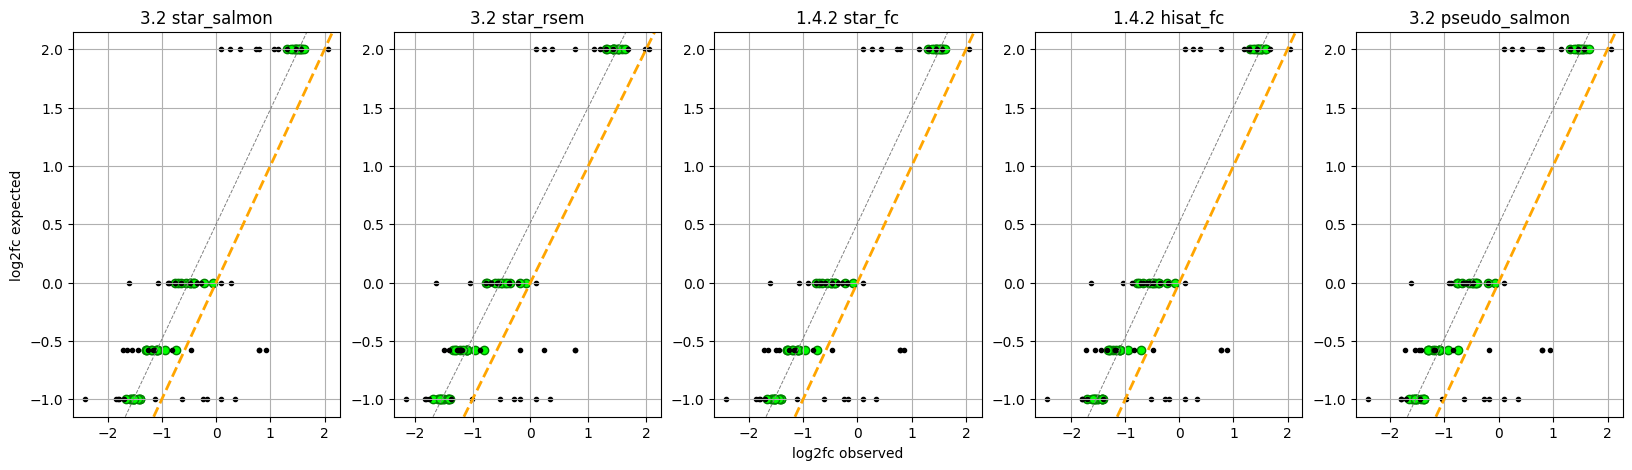

In [125]:
#drawLog2Corr(at_ercc, 6, 'viridis')
#drawLog2Corr(hs_ercc, 3, 'viridis')
drawLog2Corr(dr_ercc, 4, 'viridis')

#### Root mean squared error for each log2fc value to ercc standard

In [126]:
rmsqdf = pd.DataFrame(['gene_id','log2fc_ercc', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'])

def get_rmsq(df_in, log2val, log2col): 
    #rmsqdf = pd.DataFrame(['gene_id','log2fc_ercc', 'rmsqerr_ssal', 'rmsqerr_srsem', 'rmsqerr_sfc', 'rmsqerr_hfc', 'rmsqerr_psal'])
    #log2_ercc = [-2, 0, 0.5777669993169522, 1] #4, 1, 0.67, 0.5
    #cols = ['log2fc_ssal', 'log2fc_srsem', 'log2fc_sfc', 'log2fc_hfc', 'log2fc_psal']
    #for i in range(0,4):
    df = df_in[df_in[log2col]==log2val]
    df['rmsqerr_ssal'] = df['log2fc_ssal'].dropna().apply(lambda x: sklearn.metrics.mean_squared_error([log2val], [x], squared=False))
    df['rmsqerr_srsem'] = df['log2fc_srsem'].dropna().apply(lambda x: sklearn.metrics.mean_squared_error([log2val], [x], squared=False))
    df['rmsqerr_sfc'] = df['log2fc_sfc'].dropna().apply(lambda x: sklearn.metrics.mean_squared_error([log2val], [x], squared=False))
    df['rmsqerr_hfc'] = df['log2fc_hfc'].dropna().apply(lambda x: sklearn.metrics.mean_squared_error([log2val], [x], squared=False))
    df['rmsqerr_psal'] = df['log2fc_psal'].dropna().apply(lambda x: sklearn.metrics.mean_squared_error([log2val], [x], squared=False))
    return df[['gene_id', 'log2fc_ercc', 'subgroup_ercc', 'rmsqerr_ssal', 'rmsqerr_srsem', 'rmsqerr_sfc', 'rmsqerr_hfc', 'rmsqerr_psal']]    
    

#### Root mean squared error: values determined after filtering by baseMean value

In [127]:
bMdf = pd.DataFrame(['baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'])

def parse_bMlim(df_in, col1, col2, baseMean): #col1 is x, col2 is y scale (ercc)
    #bMdf = pd.DataFrame(['baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'])
    array_out = []
    n = []
    #filter by baseMean
    df_in = df_in.fillna(0.1)
    df_in['log2bM'] = df_in[baseMean].apply(lambda x: np.log2(x))
    for limit in range(0, 15):
        df = df_in[df_in['log2bM']>=limit]
    # fitting the model
        #reg = LinearRegression().fit(x,y)
        n.append(df.shape[0])
    # r2 to reference line (ercc data)
        r2 = sklearn.metrics.r2_score(df[col2], df[col1])
        r2_all = sklearn.metrics.r2_score(df_in[col2], df_in[col1])
        rmsqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
        array_out.append(rmsqerr)
    return (array_out, n)
        

In [128]:
def bMtable(df_in):
    bMdf = pd.DataFrame([])
    ssal = parse_bMlim(df_in, 'log2fc_ssal', 'log2fc_ercc', 'baseMean_ssal')
    srsem = parse_bMlim(df_in, 'log2fc_srsem', 'log2fc_ercc', 'baseMean_srsem')
    sfc = parse_bMlim(df_in, 'log2fc_sfc', 'log2fc_ercc', 'baseMean_sfc')
    hfc = parse_bMlim(df_in, 'log2fc_hfc', 'log2fc_ercc', 'baseMean_hfc')
    psal = parse_bMlim(df_in, 'log2fc_psal', 'log2fc_ercc', 'baseMean_psal')
    #'baseMean', 'n', 'ssal', 'srsem', 'sfc', 'hfc', 'psal'
    #bMdf['baseMean']=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    n=ssal[1]
    bMdf['ssal'] = ssal[0]
    bMdf['srsem'] = srsem[0]
    bMdf['sfc'] = sfc[0]
    bMdf['hfc'] = hfc[0]
    bMdf['psal'] = psal[0]
    
    return bMdf, n
    

In [129]:
def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d

In [130]:
hs_rmsqerr = bMtable(hs_ercc)
at_rmsqerr = bMtable(at_ercc)
dr_rmsqerr = bMtable(dr_ercc)

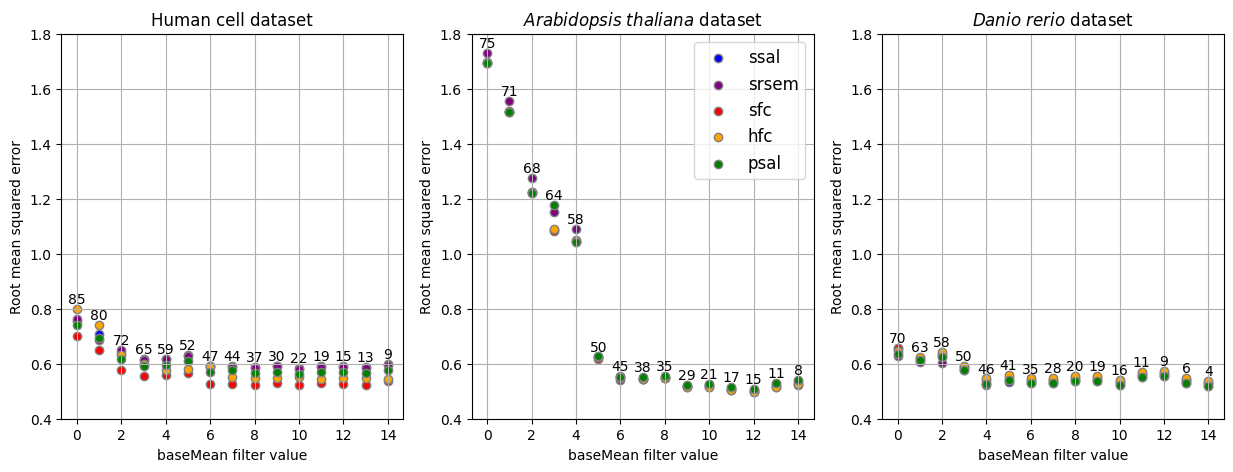

In [131]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
df1 = hs_rmsqerr[0]
df1stack = pd.DataFrame(df1.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
df2 = at_rmsqerr[0]
df2stack = pd.DataFrame(df2.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
df3 = dr_rmsqerr[0]
df3stack = pd.DataFrame(df3.stack()).reset_index().rename(columns={'level_0':'x', 0:'y'}).drop(['level_1'], axis=1)
l = 0.4
m = 1.8


ax0.scatter(df1.reset_index()['index'], df1['ssal'], c='blue', edgecolors='grey', marker='o', label='ssal')
ax0.scatter(df1.reset_index()['index'], df1['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax0.scatter(df1.reset_index()['index'], df1['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax0.scatter(df1.reset_index()['index'], df1['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax0.scatter(df1.reset_index()['index'], df1['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax0.yaxis.grid(True)
ax0.xaxis.grid(True)
ax0.set_ylabel('Root mean squared error')
ax0.set_xlabel('baseMean filter value')
ax0.set_title('Human cell dataset')
ax0.set_ylim(l,m)
# add labels (number of erccs included)
values = hs_rmsqerr[0].max(axis=1)
labels = hs_rmsqerr[0].index
text =hs_rmsqerr[1]
for i, v in enumerate(values):
    ax0.text(i, v+0.02, text[i], ha="center")
xx = np.linspace(0, 14, 200)
#fit exponential function
y_hs_stack = df1stack['y']
x_hs_stack = df1stack['x']
popt_hs, pcov_hs = curve_fit(exp_func, x_hs_stack, y_hs_stack, p0=(1, 1e-6, 1))
y_hs = exp_func(xx, *popt_hs)
#ax0.plot(xx, y_hs)

ax1.scatter(df2.reset_index()['index'], df2['ssal'], c='blue', edgecolors='grey', marker='o', label='ssal')
ax1.scatter(df2.reset_index()['index'], df2['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax1.scatter(df2.reset_index()['index'], df2['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax1.scatter(df2.reset_index()['index'], df2['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax1.scatter(df2.reset_index()['index'], df2['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
ax1.set_ylabel('Root mean squared error')
ax1.set_xlabel('baseMean filter value')
ax1.set_title('$\it{Arabidopsis}$ $\it{thaliana}$ dataset') #$\it{text you want to show in italics}$
ax1.set_ylim(l,m)
# add labels (number of erccs included)
values_at = at_rmsqerr[0].max(axis=1)
labels_at = at_rmsqerr[0].index
text_at = at_rmsqerr[1]
for i, v in enumerate(values_at):
    #print(i)
    ax1.text(i, v+0.02, text_at[i], ha="center")
#fit exponential functiony_hs_stack = df1stack['y']
x_at_stack = df2stack['x']
y_at_stack = df2stack['y']
popt_at, pcov_at = curve_fit(exp_func, x_at_stack, y_at_stack, p0=(1, 1e-6, 1))
y_at = exp_func(xx, *popt_at)
#ax1.plot(xx, y_at)

ax1.legend(loc="upper right", fontsize=12)

ax2.scatter(df3.reset_index()['index'], df3['ssal'], c='blue',  edgecolors='grey', marker='o', label='ssal')
ax2.scatter(df3.reset_index()['index'], df3['srsem'], c='purple', edgecolors='grey', marker='o', label='srsem')
ax2.scatter(df3.reset_index()['index'], df3['sfc'], c='red', edgecolors='grey', marker='o', label='sfc')
ax2.scatter(df3.reset_index()['index'], df3['hfc'], c='orange', edgecolors='grey', marker='o', label='hfc')
ax2.scatter(df3.reset_index()['index'], df3['psal'], c='green', edgecolors='grey', marker='o', label='psal')
ax2.yaxis.grid(True)
ax2.xaxis.grid(True)
ax2.set_ylabel('Root mean squared error')
ax2.set_xlabel('baseMean filter value')
ax2.set_title('$\it{Danio}$ $\it{rerio}$ dataset')
ax2.set_ylim(l,m)
# add labels (number of erccs included)
values_dr = dr_rmsqerr[0].max(axis=1)
labels_dr = dr_rmsqerr[0].index
text_dr = dr_rmsqerr[1]
for i, v in enumerate(values_dr):
    #print(i)
    ax2.text(i, v+0.02, text_dr[i], ha="center")
#fit exponential functiony_hs_stack = df1stack['y']
x_dr_stack = df3stack['x']
y_dr_stack = df3stack['y']
popt_dr, pcov_dr = curve_fit(exp_func, x_dr_stack, y_dr_stack, p0=(1, 1e-6, 1))
y_dr = exp_func(xx, *popt_dr)
#ax2.plot(xx, y_dr)

#ax2.legend(loc="upper right", fontsize=12)

In [132]:
def compareLog2fc_ax(df, pipe1, pipe2, ax, legend):
    de = df[(df['outcome_'+pipe1]=='DE') & (df['outcome_'+pipe2]=='DE')].fillna(0)
    not_de = df[(df['outcome_'+pipe1]=='not_DE') & (df['outcome_'+pipe2]=='not_DE')].fillna(0)
    de_only1 = df[(df['outcome_'+pipe1]=='DE') & (df['outcome_'+pipe2]=='not_DE')].fillna(0)
    de_only2 = df[(df['outcome_'+pipe1]=='not_DE') & (df['outcome_'+pipe2]=='DE')].fillna(0)
    
    l = min(df['log2fc_'+pipe1].min(), df['log2fc_'+pipe2].min())-0.5
    m = max(df['log2fc_'+pipe1].max(), df['log2fc_'+pipe2].max())+0.5
    
    ax.scatter(not_de['log2fc_'+pipe1], 
                not_de['log2fc_'+pipe2],
               c='grey', edgecolors='black', marker='.', label='not DE')
    ax.scatter(de_only1['log2fc_'+pipe1], 
                de_only1['log2fc_'+pipe2],
               c='limegreen', edgecolors='blue', marker='v', label='only DE '+pipe1)
    ax.scatter(de_only2['log2fc_'+pipe1], 
                de_only2['log2fc_'+pipe2],
               c='limegreen', edgecolors='green', marker='v', label='only DE '+pipe2)
    ax.scatter(de['log2fc_'+pipe1], 
                de['log2fc_'+pipe2],
               c='darkorange', edgecolors='red', marker='o', label='DE')
    #ax.set_title('Log2 foldchange '+pipe1+' vs. '+pipe2)# \n Difference in Fold Change Ratio (mix1:mix2, measured minus standard) \n colorscale: log2(transcript concentration mix1)')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel(pipe1)
    ax.set_xlabel(pipe2)
    #ax.set_xlim(l,m)
    #ax.set_ylim(l,m)
    ax.vlines(0, l, m, colors='black')
    ax.hlines(0, l, m, colors='black')
    ax.axline((1, 1), slope=1, c='yellow', ls='--', lw=1.5)
    ax.set_facecolor("lightgrey")
    if(legend == 'yes'):
        ax.legend(bbox_to_anchor=(-0.3,0.5), loc="lower right", fontsize=12)
        

In [133]:
def nofig(ax):
    ax.set_facecolor("white")
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')

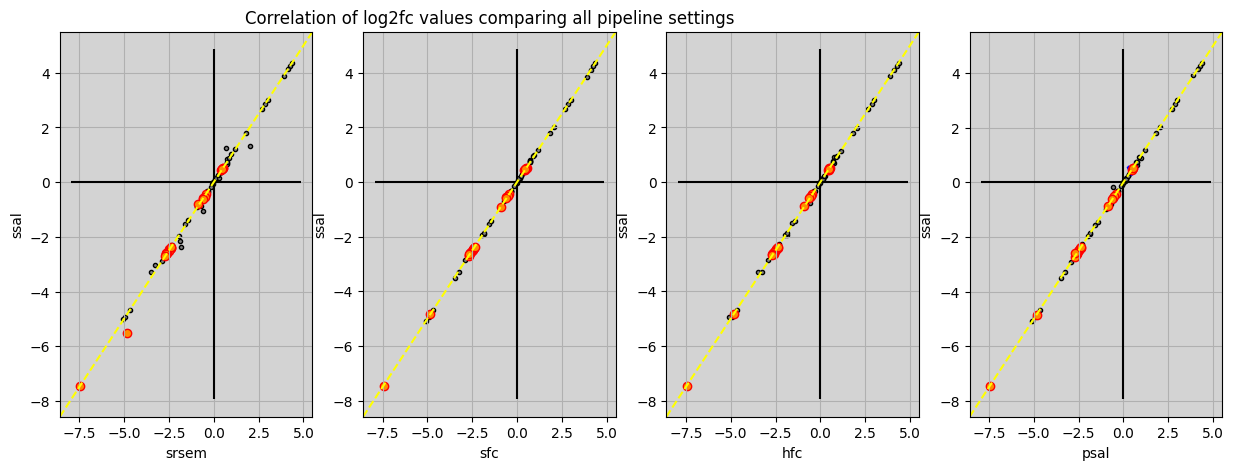

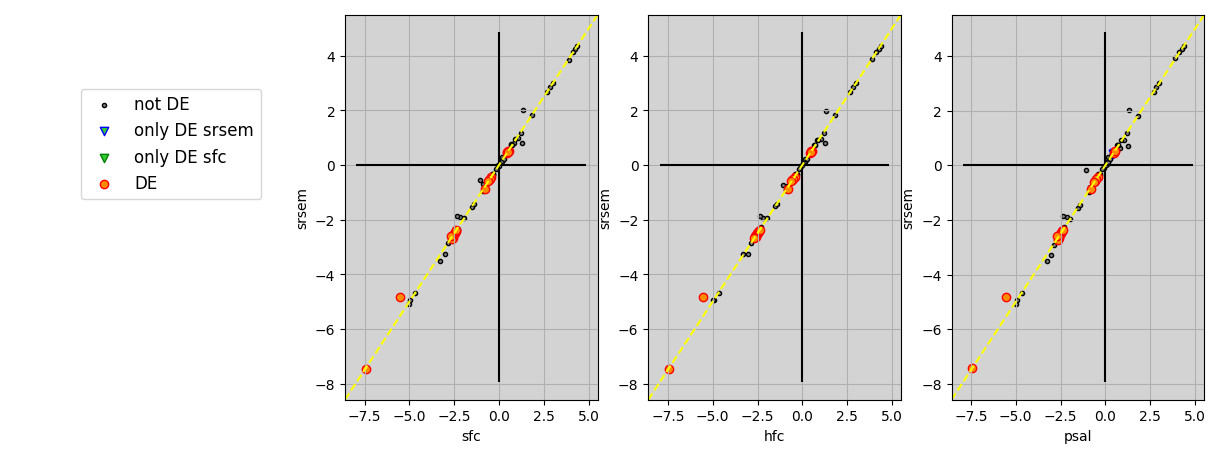

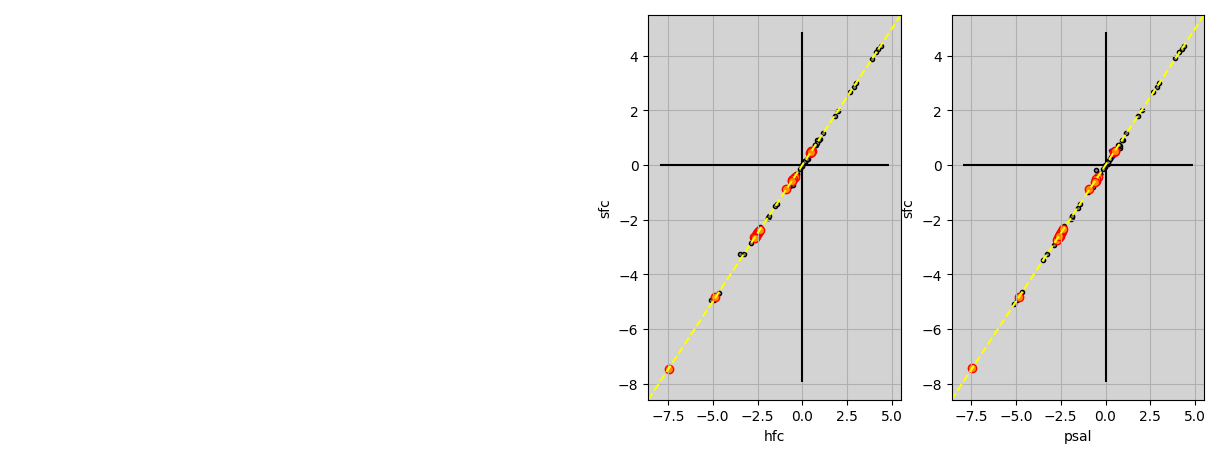

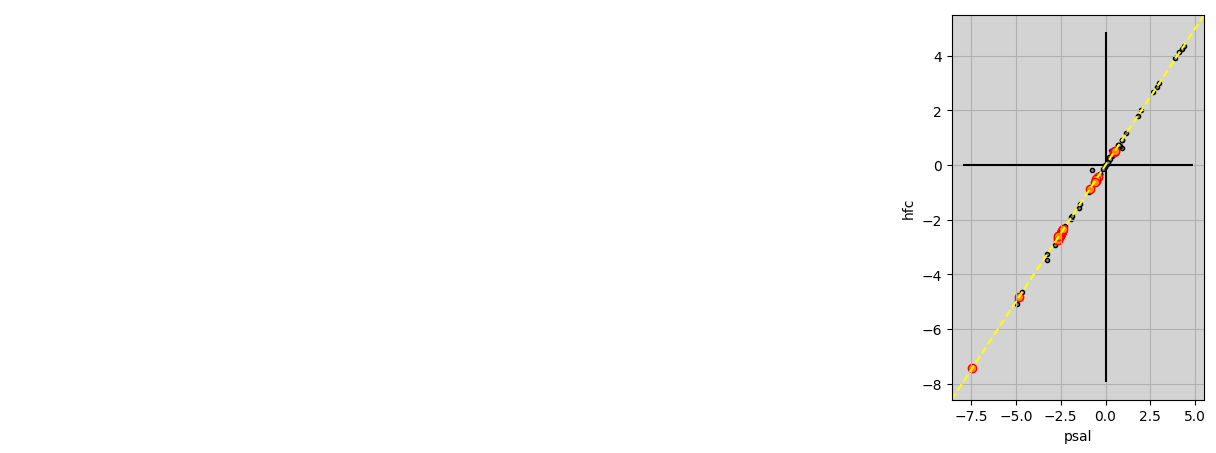

In [134]:
# ARABIDOPSIS THALIANA: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(at_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(at_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(at_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(at_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(at_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(at_ercc, 'hfc', 'psal', ax3, 'no')
#ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')


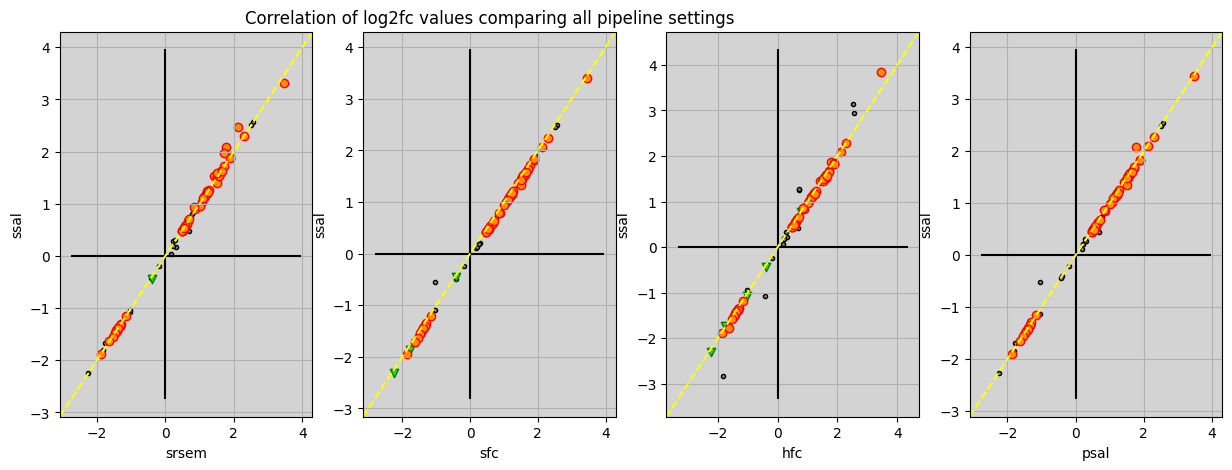

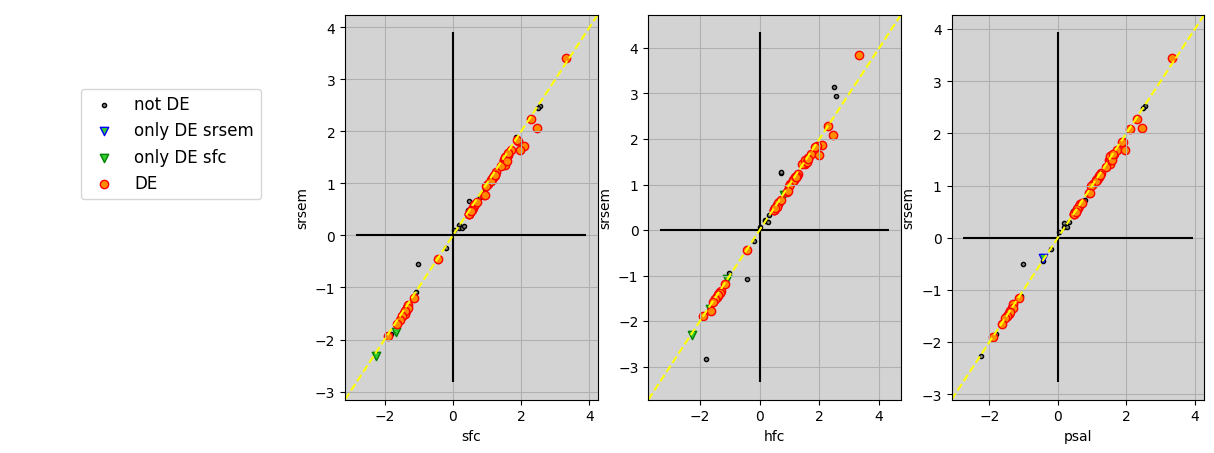

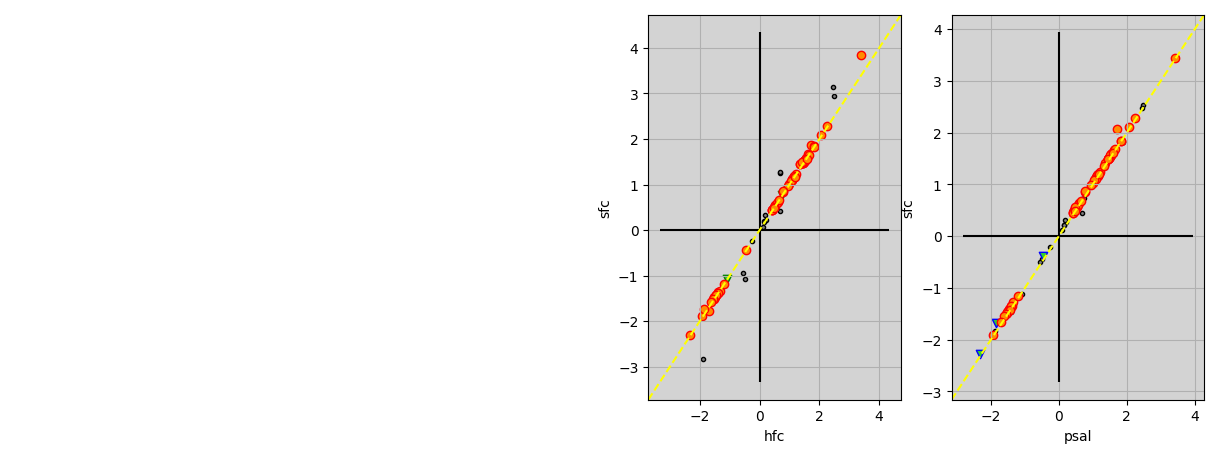

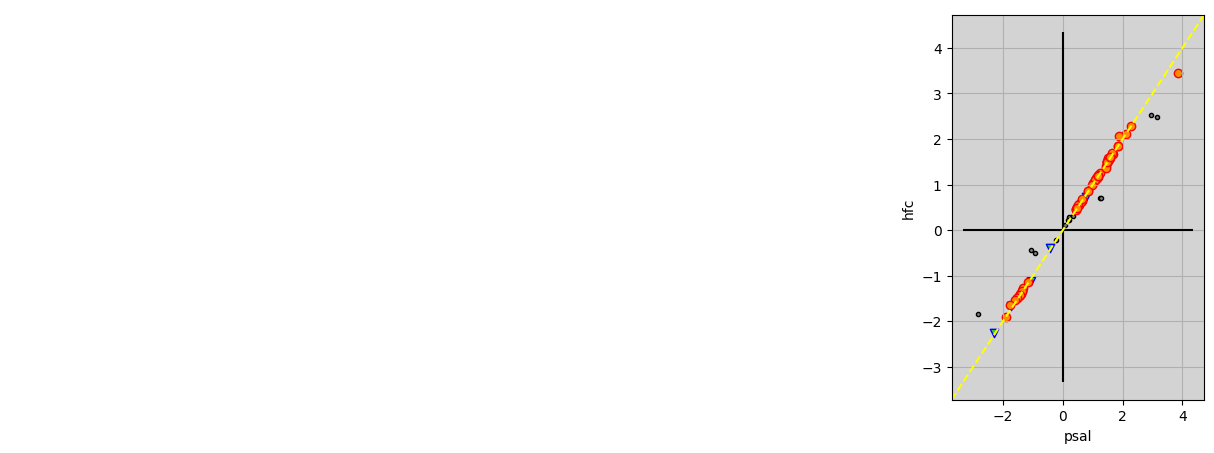

In [135]:
# HOMO SAPIENS: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(hs_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(hs_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(hs_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(hs_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(hs_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(hs_ercc, 'hfc', 'psal', ax3, 'no')

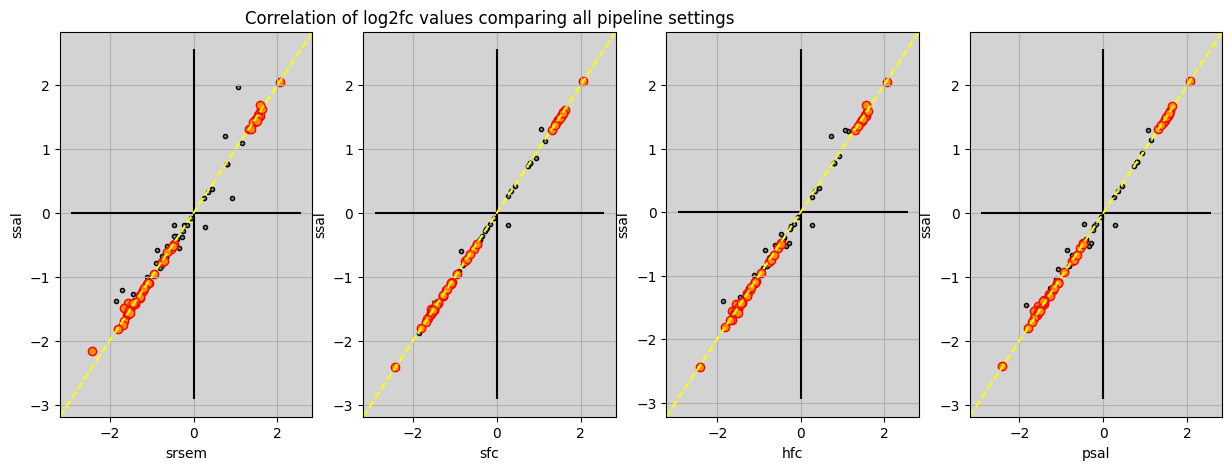

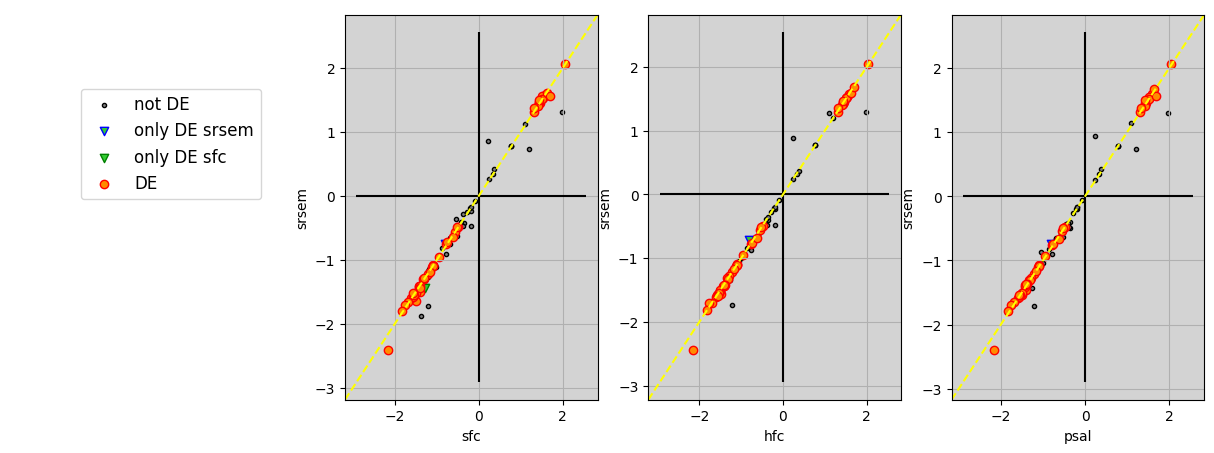

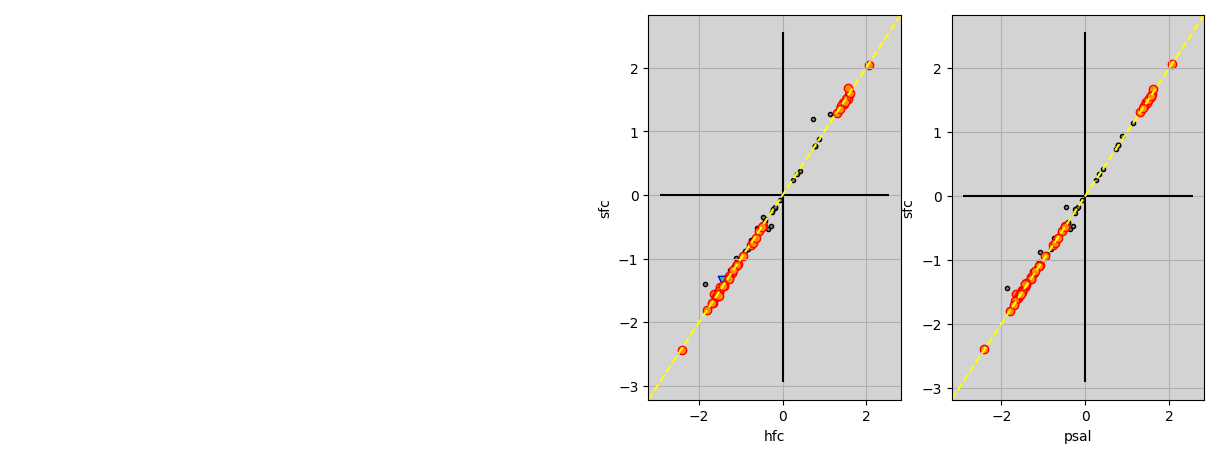

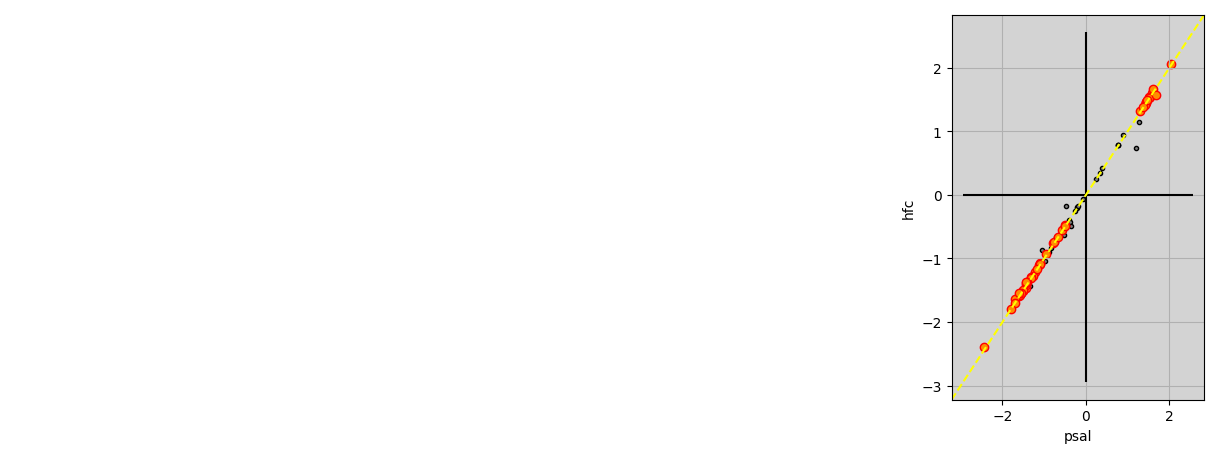

In [136]:
# DANIO RERIO: Draw matrix plot comparing log2 featurecount outcome between all pipeline settings
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
compareLog2fc_ax(dr_ercc, 'ssal', 'srsem', ax0, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'sfc', ax1, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'ssal', 'psal', ax3, 'no')
#ax0.set_xlabel('Log10(Transcripts per Million)')
ax1.set_title('Correlation of log2fc values comparing all pipeline settings')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
compareLog2fc_ax(dr_ercc, 'srsem', 'sfc', ax1, 'yes')
compareLog2fc_ax(dr_ercc, 'srsem', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'srsem', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
compareLog2fc_ax(dr_ercc, 'sfc', 'hfc', ax2, 'no')
compareLog2fc_ax(dr_ercc, 'sfc', 'psal', ax3, 'no')

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
nofig(ax0)
nofig(ax1)
nofig(ax2)
compareLog2fc_ax(dr_ercc, 'hfc', 'psal', ax3, 'no')

### ERCC spike-in concentration log10 (y) vs. log10(TPM)
 as in Hoffmann et al. (2019)

#### ARABIDOPSIS: Prepare dataframes with ercc mix concentration and TPM data

In [139]:
# join featurecounts data (star + featurecounts)
sfc_flight1 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/flight1.txt', sep='\t').rename(columns={'TPM':'flight1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_flight2 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/flight2.txt', sep='\t').rename(columns={'TPM':'flight2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_flight3 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/flight3.txt', sep='\t').rename(columns={'TPM':'flight3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground1 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/ground1.txt', sep='\t').rename(columns={'TPM':'ground1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground2 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/ground2.txt', sep='\t').rename(columns={'TPM':'ground2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_ground3 = pd.read_csv('../Data/deseq_tairdata/sfc_tpm/ground3.txt', sep='\t').rename(columns={'TPM':'ground3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)

#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_flight1, sfc_flight2, sfc_flight3, sfc_ground1, sfc_ground2, sfc_ground3]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
at_sfc_tpm = pd.concat([d.set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [140]:
# join featurecounts data (hisat + featurecounts)
hfc_flight1 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/flight1.txt', sep='\t').rename(columns={'TPM':'flight1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_flight2 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/flight2.txt', sep='\t').rename(columns={'TPM':'flight2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_flight3 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/flight3.txt', sep='\t').rename(columns={'TPM':'flight3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground1 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/ground1.txt', sep='\t').rename(columns={'TPM':'ground1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground2 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/ground2.txt', sep='\t').rename(columns={'TPM':'ground2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_ground3 = pd.read_csv('../Data/deseq_tairdata/hfc_tpm/ground3.txt', sep='\t').rename(columns={'TPM':'ground3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)

#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_flight1, hfc_flight2, hfc_flight3, hfc_ground1, hfc_ground2, hfc_ground3]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
at_hfc_tpm = pd.concat([d.set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [174]:
at_sfc_tpm.to_csv('../Data/deseq_tairdata/sfc_tpm.tsv', sep='\t', index=None)

In [173]:
at_hfc_tpm.to_csv('../Data/deseq_tairdata/hfc_tpm.tsv', sep='\t', index=None)

In [143]:
at_ssal_tpm = pd.read_csv('../Data/deseq_tairdata/ssal_tpm.tsv', sep='\t')
at_psal_tpm = pd.read_csv('../Data/deseq_tairdata/psal_tpm.tsv', sep='\t')
at_srsem_tpm = pd.read_csv('../Data/deseq_tairdata/srsem_tpm.tsv', sep='\t')

In [144]:
ercc_conc = ercc_df[['gene_id', 'concentration in Mix 1 (attomoles/ul)',
       'concentration in Mix 2 (attomoles/ul)']]

In [146]:
# merge ercc concentration and tpm values from pipeline runs 
at_conc_tpm = ercc_conc.merge(at_ssal_tpm.merge(at_srsem_tpm.merge(at_sfc_tpm.merge(at_hfc_tpm.merge(at_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))


In [147]:
# append '_ssal' to star_salmon columns
at_conc_tpm = at_conc_tpm.rename(columns={'flight1':'flight1_ssal','flight2':'flight2_ssal', 'flight3':'flight3_ssal', 'ground1':'ground1_ssal', 'ground2':'ground2_ssal', 'ground3':'ground3_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)


In [148]:
# Apply log10 to all columns
at_log10 = at_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
at_log2 = at_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)

/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [149]:
flight_ssal = ['flight1_ssal', 'flight2_ssal','flight3_ssal'] 
ground_ssal = ['ground1_ssal', 'ground2_ssal', 'ground3_ssal']
#ssal_all = ['flight1_ssal', 'flight2_ssal','flight3_ssal', 'ground1_ssal', 'ground2_ssal', 'ground3_ssal']
flight_srsem = ['flight1_srsem', 'flight2_srsem', 'flight3_srsem']
ground_srsem = ['ground1_srsem', 'ground2_srsem', 'ground3_srsem']
flight_sfc = ['flight1_sfc','flight2_sfc', 'flight3_sfc']
ground_sfc = ['ground1_sfc', 'ground2_sfc','ground3_sfc']
flight_hfc = ['flight1_hfc', 'flight2_hfc', 'flight3_hfc']
ground_hfc = ['ground1_hfc', 'ground2_hfc', 'ground3_hfc']
flight_psal = ['flight1_psal','flight2_psal', 'flight3_psal'] 
ground_psal = ['ground1_psal', 'ground2_psal','ground3_psal']
lol = [flight_ssal, ground_ssal, flight_srsem, ground_srsem, flight_sfc, ground_sfc, flight_hfc, ground_hfc, flight_psal, ground_psal]


at_tpm_zero = at_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
at_tpm_zero = at_tpm_zero[at_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',at_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', at_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',at_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', at_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol:
    print(lst, at_conc_tpm[(at_conc_tpm[lst[0]]==0) & (at_conc_tpm[lst[1]]==0) & (at_conc_tpm[lst[2]]==0)].shape[0])
print('Undetected ercc spike-ins: ',at_tpm_zero['gene_id'].tolist())

range Mix1:  0.01430512 to 1.83105469
range Mix2:  0.00715256 to 0.45776367
['flight1_ssal', 'flight2_ssal', 'flight3_ssal'] 19
['ground1_ssal', 'ground2_ssal', 'ground3_ssal'] 19
['flight1_srsem', 'flight2_srsem', 'flight3_srsem'] 19
['ground1_srsem', 'ground2_srsem', 'ground3_srsem'] 19
['flight1_sfc', 'flight2_sfc', 'flight3_sfc'] 19
['ground1_sfc', 'ground2_sfc', 'ground3_sfc'] 19
['flight1_hfc', 'flight2_hfc', 'flight3_hfc'] 19
['ground1_hfc', 'ground2_hfc', 'ground3_hfc'] 19
['flight1_psal', 'flight2_psal', 'flight3_psal'] 19
['ground1_psal', 'ground2_psal', 'ground3_psal'] 19
Undetected ercc spike-ins:  ['ERCC-00134', 'ERCC-00156', 'ERCC-00083', 'ERCC-00142', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00024', 'ERCC-00016', 'ERCC-00098', 'ERCC-00057', 'ERCC-00041', 'ERCC-00048']


In [150]:
at_test = at_tpm_zero.set_index('gene_id').drop(['concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'], axis=1)#[(at_tpm_zero == 0)]
at_test = at_test[(at_test == 0)].dropna()
at_undetected = at_test.index.tolist()
at_undetected

['ERCC-00134',
 'ERCC-00156',
 'ERCC-00083',
 'ERCC-00142',
 'ERCC-00138',
 'ERCC-00117',
 'ERCC-00075',
 'ERCC-00024',
 'ERCC-00016',
 'ERCC-00098',
 'ERCC-00057',
 'ERCC-00041',
 'ERCC-00048']

#### Homo sapiens: Prepare dataframes with ercc mix concentration and TPM data

In [152]:
# join featurecounts data (star + featurecounts)
sfc_A1 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/A1.txt', sep='\t').rename(columns={'TPM':'A1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A2 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/A2.txt', sep='\t').rename(columns={'TPM':'A2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A3 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/A3.txt', sep='\t').rename(columns={'TPM':'A3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A4 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/A4.txt', sep='\t').rename(columns={'TPM':'A4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_A5 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/A5.txt', sep='\t').rename(columns={'TPM':'A5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B1 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/B1.txt', sep='\t').rename(columns={'TPM':'B1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B2 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/B2.txt', sep='\t').rename(columns={'TPM':'B2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B3 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/B3.txt', sep='\t').rename(columns={'TPM':'B3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B4 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/B4.txt', sep='\t').rename(columns={'TPM':'B4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_B5 = pd.read_csv('../Data/deseq_hsdata/sfc_tpm/B5.txt', sep='\t').rename(columns={'TPM':'B5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_A1, sfc_A2, sfc_A3, sfc_A4, sfc_A5, sfc_B1, sfc_B2, sfc_B3, sfc_B4, sfc_B5]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
hs_sfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [155]:
# join featurecounts data (star + featurecounts)
hfc_A1 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/A1.txt', sep='\t').rename(columns={'TPM':'A1'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A2 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/A2.txt', sep='\t').rename(columns={'TPM':'A2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A3 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/A3.txt', sep='\t').rename(columns={'TPM':'A3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A4 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/A4.txt', sep='\t').rename(columns={'TPM':'A4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_A5 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/A5.txt', sep='\t').rename(columns={'TPM':'A5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B1 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/B1.txt', sep='\t').rename(columns={'TPM':'B1'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B2 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/B2.txt', sep='\t').rename(columns={'TPM':'B2'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B3 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/B3.txt', sep='\t').rename(columns={'TPM':'B3'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B4 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/B4.txt', sep='\t').rename(columns={'TPM':'B4'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_B5 = pd.read_csv('../Data/deseq_hsdata/hfc_tpm/B5.txt', sep='\t').rename(columns={'TPM':'B5'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_A1, hfc_A2, hfc_A3, hfc_A4, hfc_A5, hfc_B1, hfc_B2, hfc_B3, hfc_B4, hfc_B5]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
hs_hfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [172]:
hs_sfc_tpm.to_csv('../Data/deseq_hsdata/sfc_tpm.tsv', sep='\t', index=None)
hs_hfc_tpm.to_csv('../Data/deseq_hsdata/hfc_tpm.tsv', sep='\t', index=None)

In [156]:
hs_ssal_tpm = pd.read_csv('../Data/deseq_hsdata/ssal_tpm.tsv', sep='\t')
hs_psal_tpm = pd.read_csv('../Data/deseq_hsdata/psal_tpm.tsv', sep='\t')
hs_srsem_tpm = pd.read_csv('../Data/deseq_hsdata/srsem_tpm.tsv', sep='\t')

In [157]:
# merge ercc concentration and tpm values from pipeline runs 
hs_conc_tpm = ercc_conc.merge(hs_ssal_tpm.merge(hs_srsem_tpm.merge(hs_sfc_tpm.merge(hs_hfc_tpm.merge(hs_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))
# append '_ssal' to star_salmon columns
hs_conc_tpm = hs_conc_tpm.rename(columns={'A1':'A1_ssal','A2':'A2_ssal', 'A3':'A3_ssal', 'A4':'A4_ssal', 'A5':'A5_ssal', 'B1':'B1_ssal', 'B2':'B2_ssal', 'B3':'B3_ssal', 'B4':'B4_ssal', 'B5':'B5_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)
# Apply log10 to all columns
hs_log10 = hs_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
hs_log2 = hs_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)


/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#hs_conc_tpm.columns

In [158]:
A_ssal = ['A1_ssal', 'A2_ssal', 'A3_ssal', 'A4_ssal', 'A5_ssal'] 
B_ssal = ['B1_ssal', 'B2_ssal', 'B3_ssal', 'B4_ssal', 'B5_ssal']
A_srsem = ['A1_srsem', 'A2_srsem', 'A3_srsem', 'A4_srsem', 'A5_srsem']
B_srsem = ['B1_srsem', 'B2_srsem', 'B3_srsem', 'B4_srsem', 'B5_srsem' ]
A_sfc = ['A1_sfc','A2_sfc', 'A3_sfc', 'A4_sfc', 'A5_sfc']
B_sfc = ['B1_sfc', 'B2_sfc','B3_sfc', 'B4_sfc', 'B5_sfc']
A_hfc = ['A1_hfc', 'A2_hfc', 'A3_hfc', 'A4_hfc', 'A5_hfc']
B_hfc = ['B1_hfc', 'B2_hfc', 'B3_hfc', 'B4_hfc', 'B5_hfc']
A_psal = ['A1_psal','A2_psal', 'A3_psal', 'A4_psal', 'A5_psal'] 
B_psal = ['B1_psal', 'B2_psal','B3_psal', 'B4_psal', 'B5_psal']
lol_hs = [A_ssal, B_ssal, A_srsem, B_srsem, A_sfc, B_sfc, A_hfc, B_hfc, A_psal, B_psal]


hs_tpm_zero = hs_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
hs_tpm_zero = hs_tpm_zero[hs_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol_hs:
    sub_hs = hs_conc_tpm[(hs_conc_tpm[lst[0]]==0) & (hs_conc_tpm[lst[1]]==0) & (hs_conc_tpm[lst[2]]==0) & (hs_conc_tpm[lst[3]]==0)& (hs_conc_tpm[lst[4]]==0)]
    print(lst, hs_conc_tpm[(hs_conc_tpm[lst[0]]==0) & (hs_conc_tpm[lst[1]]==0) & (hs_conc_tpm[lst[2]]==0)& (hs_conc_tpm[lst[3]]==0)& (hs_conc_tpm[lst[4]]==0)].shape[0])
    print(sub_hs['gene_id'].to_list())
print('Undetected ercc spike-ins: ',hs_tpm_zero['gene_id'].tolist())

range Mix1:  nan to nan
range Mix2:  nan to nan
['A1_ssal', 'A2_ssal', 'A3_ssal', 'A4_ssal', 'A5_ssal'] 2
['ERCC-00057', 'ERCC-00048']
['B1_ssal', 'B2_ssal', 'B3_ssal', 'B4_ssal', 'B5_ssal'] 2
['ERCC-00017', 'ERCC-00083']
['A1_srsem', 'A2_srsem', 'A3_srsem', 'A4_srsem', 'A5_srsem'] 2
['ERCC-00057', 'ERCC-00048']
['B1_srsem', 'B2_srsem', 'B3_srsem', 'B4_srsem', 'B5_srsem'] 2
['ERCC-00017', 'ERCC-00083']
['A1_sfc', 'A2_sfc', 'A3_sfc', 'A4_sfc', 'A5_sfc'] 2
['ERCC-00057', 'ERCC-00048']
['B1_sfc', 'B2_sfc', 'B3_sfc', 'B4_sfc', 'B5_sfc'] 2
['ERCC-00017', 'ERCC-00083']
['A1_hfc', 'A2_hfc', 'A3_hfc', 'A4_hfc', 'A5_hfc'] 2
['ERCC-00057', 'ERCC-00048']
['B1_hfc', 'B2_hfc', 'B3_hfc', 'B4_hfc', 'B5_hfc'] 2
['ERCC-00017', 'ERCC-00083']
['A1_psal', 'A2_psal', 'A3_psal', 'A4_psal', 'A5_psal'] 2
['ERCC-00057', 'ERCC-00048']
['B1_psal', 'B2_psal', 'B3_psal', 'B4_psal', 'B5_psal'] 2
['ERCC-00017', 'ERCC-00083']
Undetected ercc spike-ins:  []


In [159]:
mix1_undetected = ['ERCC-00057', 'ERCC-00048']
mix2_undetected = ['ERCC-00017', 'ERCC-00083']
#print('range Mix1: ',hs_conc_tpm[hs_conc_tpm['gene_id']==(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
#print('range Mix2: ',hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', hs_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
print(hs_conc_tpm[hs_conc_tpm['gene_id'].isin(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].tolist())
print(hs_conc_tpm[hs_conc_tpm['gene_id'].isin(mix2_undetected)]['concentration in Mix 2 (attomoles/ul)'].tolist())

[0.01430512, 0.01430512]
[0.02861023, 0.00715256]


#### Danio rerio: prepare dataframes

In [160]:
# join featurecounts data (star + featurecounts)
sfc_sham11 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_11.txt', sep='\t').rename(columns={'TPM':'sham11'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham12 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_12.txt', sep='\t').rename(columns={'TPM':'sham12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham21 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_21.txt', sep='\t').rename(columns={'TPM':'sham21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham22 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_22.txt', sep='\t').rename(columns={'TPM':'sham22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham31 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_31.txt', sep='\t').rename(columns={'TPM':'sham31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sham32 = pd.read_csv('../Data/deseq_daniodata/sfc/sham_32.txt', sep='\t').rename(columns={'TPM':'sham32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs11 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_11.txt', sep='\t').rename(columns={'TPM':'sbs11'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs12 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_12.txt', sep='\t').rename(columns={'TPM':'sbs12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs21 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_21.txt', sep='\t').rename(columns={'TPM':'sbs21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs22 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_22.txt', sep='\t').rename(columns={'TPM':'sbs22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs31 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_31.txt', sep='\t').rename(columns={'TPM':'sbs31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
sfc_sbs32 = pd.read_csv('../Data/deseq_daniodata/sfc/sbs_32.txt', sep='\t').rename(columns={'TPM':'sbs32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [sfc_sham11, sfc_sham12, sfc_sham21, sfc_sham22, sfc_sham31, sfc_sham32, sfc_sbs11, sfc_sbs12, sfc_sbs21, sfc_sbs22, sfc_sbs31, sfc_sbs32]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
dr_sfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [161]:
# join featurecounts data (star + featurecounts)
hfc_sham11 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_11.txt', sep='\t').rename(columns={'TPM':'sham11'}).drop(['Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham12 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_12.txt', sep='\t').rename(columns={'TPM':'sham12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham21 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_21.txt', sep='\t').rename(columns={'TPM':'sham21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham22 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_22.txt', sep='\t').rename(columns={'TPM':'sham22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham31 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_31.txt', sep='\t').rename(columns={'TPM':'sham31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sham32 = pd.read_csv('../Data/deseq_daniodata/hfc/sham_32.txt', sep='\t').rename(columns={'TPM':'sham32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs11 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_11.txt', sep='\t').rename(columns={'TPM':'sbs11'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs12 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_12.txt', sep='\t').rename(columns={'TPM':'sbs12'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs21 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_21.txt', sep='\t').rename(columns={'TPM':'sbs21'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs22 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_22.txt', sep='\t').rename(columns={'TPM':'sbs22'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs31 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_31.txt', sep='\t').rename(columns={'TPM':'sbs31'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)
hfc_sbs32 = pd.read_csv('../Data/deseq_daniodata/hfc/sbs_32.txt', sep='\t').rename(columns={'TPM':'sbs32'}).drop(['Gene Name','Reference', 'Strand', 'Start', 'End', 'Coverage', 'FPKM'], axis=1)



#lodf = [df1, df2, df3, df4, df5]
lodf = [hfc_sham11, hfc_sham12, hfc_sham21, hfc_sham22, hfc_sham31, hfc_sham32, hfc_sbs11, hfc_sbs12, hfc_sbs21, hfc_sbs22, hfc_sbs31, hfc_sbs32]

#df = pd.concat([d.set_index('post_id') for d in lodf], axis=1).reset_index()
dr_hfc_tpm = pd.concat([d.drop_duplicates('Gene ID').set_index('Gene ID') for d in lodf], axis=1).reset_index().rename(columns={'Gene ID':'gene_id', 'Gene Name':'gene_name'})

In [171]:
dr_sfc_tpm.to_csv('../Data/deseq_daniodata/sfc_tpm.tsv', sep='\t', index=None)
dr_hfc_tpm.to_csv('../Data/deseq_daniodata/hfc_tpm.tsv', sep='\t', index=None)

In [162]:
dr_colnames = {'SRR3655791':'sham11', 'SRR3655792':'sham12', 'SRR3655793':'sham21',
       'SRR3655794':'sham22', 'SRR3655795':'sham31', 'SRR3655796':'sham32', 'SRR3655797':'sbs11', 'SRR3655798':'sbs12',
       'SRR3655799':'sbs21', 'SRR3655800':'sbs22', 'SRR3655801':'sbs31', 'SRR3655802':'sbs32'}
dr_ssal_tpm = pd.read_csv('../Data/deseq_daniodata/ssal_tpm.tsv', sep='\t').rename(columns=dr_colnames)
dr_psal_tpm = pd.read_csv('../Data/deseq_daniodata/psal_tpm.tsv', sep='\t').rename(columns=dr_colnames)
dr_srsem_tpm = pd.read_csv('../Data/deseq_daniodata/srsem_tpm.tsv', sep='\t').rename(columns=dr_colnames)

In [163]:
# merge ercc concentration and tpm values from pipeline runs 
dr_conc_tpm = ercc_conc.merge(dr_ssal_tpm.merge(dr_srsem_tpm.merge(dr_sfc_tpm.merge(dr_hfc_tpm.merge(dr_psal_tpm, on='gene_id', suffixes=('', '_psal')), on='gene_id', suffixes=('', '_hfc')), on='gene_id', suffixes=('', '_sfc')), on='gene_id', suffixes=('', '_srsem')), on='gene_id', suffixes=('', '_ssal'))
# append '_ssal' to star_salmon columns
dr_conc_tpm = dr_conc_tpm.rename(columns={'sham11':'sham11_ssal','sham12':'sham12_ssal', 'sham21':'sham21_ssal', 'sham22':'sham22_ssal', 'sham31':'sham31_ssal', 'sham32':'sham32_ssal','sbs11':'sbs11_ssal','sbs12':'sbs12_ssal', 'sbs21':'sbs21_ssal', 'sbs22':'sbs22_ssal', 'sbs31':'sbs31_ssal', 'sbs32':'sbs32_ssal'}).drop(['gene_name','gene_name_srsem', 'gene_name_hfc', 'gene_name_psal'], axis=1)
# Apply log10 to all columns
dr_log10 = dr_conc_tpm.apply(lambda x: np.log10(x)if np.issubdtype(x.dtype, np.number) else x)
# Apply log2 to all columns
dr_log2 = dr_conc_tpm.apply(lambda x: np.log2(x)if np.issubdtype(x.dtype, np.number) else x)


/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lp1/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#dr_conc_tpm.columns

In [164]:
sham_ssal = ['sham11_ssal', 'sham12_ssal', 'sham21_ssal', 'sham22_ssal', 'sham31_ssal', 'sham32_ssal'] 
sbs_ssal = ['sbs11_ssal', 'sbs12_ssal', 'sbs21_ssal', 'sbs22_ssal', 'sbs31_ssal','sbs32_ssal']
sham_srsem = ['sham11_srsem', 'sham12_srsem','sham21_srsem', 'sham22_srsem', 'sham31_srsem', 'sham32_srsem']
sbs_srsem = ['sbs11_srsem', 'sbs12_srsem', 'sbs21_srsem', 'sbs22_srsem', 'sbs31_srsem', 'sbs32_srsem']
sham_sfc = ['sham11_sfc', 'sham12_sfc', 'sham21_sfc', 'sham22_sfc', 'sham31_sfc', 'sham32_sfc']
sbs_sfc = ['sbs11_sfc', 'sbs12_sfc', 'sbs21_sfc', 'sbs22_sfc', 'sbs31_sfc', 'sbs32_sfc']
sham_hfc = ['sham11_hfc','sham12_hfc', 'sham21_hfc', 'sham22_hfc', 'sham31_hfc', 'sham32_hfc']
sbs_hfc = ['sbs11_hfc', 'sbs12_hfc', 'sbs21_hfc', 'sbs22_hfc', 'sbs31_hfc', 'sbs32_hfc']
sham_psal = ['sham11_psal', 'sham12_psal', 'sham21_psal', 'sham22_psal','sham31_psal', 'sham32_psal'] 
sbs_psal = ['sbs11_psal', 'sbs12_psal', 'sbs21_psal','sbs22_psal', 'sbs31_psal', 'sbs32_psal']
lol_dr = [sham_ssal, sbs_ssal, sham_srsem, sbs_srsem, sham_sfc, sbs_sfc, sham_hfc, sbs_hfc, sham_psal, sbs_psal]


dr_tpm_zero = dr_conc_tpm.set_index(['gene_id', 'concentration in Mix 1 (attomoles/ul)', 'concentration in Mix 2 (attomoles/ul)', 'transcript_id(s)'])
dr_tpm_zero = dr_tpm_zero[dr_tpm_zero == 0].dropna().reset_index()
print('range Mix1: ',dr_tpm_zero['concentration in Mix 1 (attomoles/ul)'].min(),'to', dr_tpm_zero['concentration in Mix 1 (attomoles/ul)'].max() )
print('range Mix2: ',dr_tpm_zero['concentration in Mix 2 (attomoles/ul)'].min(),'to', dr_tpm_zero['concentration in Mix 2 (attomoles/ul)'].max() )
for lst in lol_dr:
    sub_dr = dr_conc_tpm[(dr_conc_tpm[lst[0]]==0) & (dr_conc_tpm[lst[1]]==0) & (dr_conc_tpm[lst[2]]==0) & (dr_conc_tpm[lst[3]]==0) & (dr_conc_tpm[lst[4]]==0) & (dr_conc_tpm[lst[5]]==0)]
    print(lst, sub_dr.shape[0])
    print(sub_dr['gene_id'].to_list())
print('Undetected ercc spike-ins: ',dr_tpm_zero['gene_id'].tolist())

range Mix1:  0.01430512 to 0.02861023
range Mix2:  0.00715256 to 0.02861023
['sham11_ssal', 'sham12_ssal', 'sham21_ssal', 'sham22_ssal', 'sham31_ssal', 'sham32_ssal'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
['sbs11_ssal', 'sbs12_ssal', 'sbs21_ssal', 'sbs22_ssal', 'sbs31_ssal', 'sbs32_ssal'] 7
['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
['sham11_srsem', 'sham12_srsem', 'sham21_srsem', 'sham22_srsem', 'sham31_srsem', 'sham32_srsem'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
['sbs11_srsem', 'sbs12_srsem', 'sbs21_srsem', 'sbs22_srsem', 'sbs31_srsem', 'sbs32_srsem'] 7
['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
['sham11_sfc', 'sham12_sfc', 'sham21_sfc', 'sham22_sfc', 'sham31_sfc', 'sham32_sfc'] 8
['ERCC-00083', 'ERCC-00104', 'ERCC-00138'

In [165]:
mix1_undetected = ['ERCC-00083', 'ERCC-00104', 'ERCC-00138', 'ERCC-00117', 'ERCC-00075', 'ERCC-00016', 'ERCC-00086', 'ERCC-00048']
mix2_undetected = ['ERCC-00156', 'ERCC-00017', 'ERCC-00083', 'ERCC-00075', 'ERCC-00098', 'ERCC-00057', 'ERCC-00048']
#16,48,75,83,86,104,117,138
#17,48,57,75,83,98,156
#three in common. 48,75,83
print(dr_conc_tpm[dr_conc_tpm['gene_id'].isin(mix1_undetected)]['concentration in Mix 1 (attomoles/ul)'].tolist())
print(dr_conc_tpm[dr_conc_tpm['gene_id'].isin(mix2_undetected)]['concentration in Mix 2 (attomoles/ul)'].tolist())

[0.02861023, 0.22888184, 0.11444092, 0.05722046, 0.01430512, 0.22888184, 0.11444092, 0.01430512]
[0.11444092, 0.02861023, 0.00715256, 0.01430512, 0.08583069, 0.02145767, 0.02861023]


In [166]:
# save TPM dataframes
hs_conc_tpm.to_csv('../Data/hs_conc_tpm.tsv', sep='\t', index=None)
at_conc_tpm.to_csv('../Data/at_conc_tpm.tsv', sep='\t', index=None)
dr_conc_tpm.to_csv('../Data/dr_conc_tpm.tsv', sep='\t', index=None)

#### Functions for drawing graph

In [ ]:
# create a df for flattened data (concentration and tpm) for one pipeline run
def flatten6(df, col1, col2, pipe):
    df1 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'1_'+pipe]]
    df2 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'2_'+pipe]]
    df3 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'3_'+pipe]]
    df4 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'1_'+pipe]]
    df5 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'2_'+pipe]]
    df6 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'3_'+pipe]]
    df_out = pd.DataFrame(np.concatenate((df1.values, df2.values, df3.values, df4.values, df5.values, df6.values), axis=0))
    df_out.columns = ['gene_id','conc_mix', 'tpm_'+pipe]
    return df_out

In [ ]:
def flatten12(df, col1, col2, pipe):
    df1 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'11_'+pipe]]
    df2 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'12_'+pipe]]
    df3 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col1+'21_'+pipe]]
    df4 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'22_'+pipe]]
    df5 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'31_'+pipe]]
    df6 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col1+'32_'+pipe]]
    df7 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'11_'+pipe]]
    df8 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'12_'+pipe]]
    df9 = df[['gene_id','concentration in Mix 1 (attomoles/ul)', col2+'21_'+pipe]]
    df10 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'22_'+pipe]]
    df11 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'31_'+pipe]]
    df12 = df[['gene_id','concentration in Mix 2 (attomoles/ul)', col2+'32_'+pipe]]
    df_out = pd.DataFrame(np.concatenate((df1.values, df2.values, df3.values, df4.values, df5.values, df6.values, df7.values, df8.values, df9.values, df10.values, df11.values, df12.values), axis=0))
    df_out.columns = ['gene_id','conc_mix', 'tpm_'+pipe]
    return df_out

In [ ]:
#draw the scatter plot with log10 concentration and tpm values for one pipeline
def draw_conctpm(df, pipe):
    df = flatten(df, pipe)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(0)
    #df = df.fillna(0)
    col1 = 'tpm_'+pipe
    col2 = 'conc_mix'
#draw scatterplot
    fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=(10,10))
    ax.scatter(df[col1], df[col2], c='grey', edgecolors='grey', marker='.')
    ax.axline((1, 1), slope=1, c='yellow', ls='--', lw=3)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='grey', ls='--', lw=0.7)
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
# print regression params
    #print(f"y = {a:.2}*x + {b:.2}")
    print('y = {:.3}x + ({:.3})'.format(a,b))
    print(f'R Squared: {reg.score(x,y):.3}')
    #print('log2 feature counts shift: {:.3}'.format(-b/a))
    print('Reference R Squared: {:.3}'.format(r2))

In [ ]:
def draw_ax(df, col1, col2, pipe, ax, flatten, logbase):
    if(flatten==6):
        df = flatten6(df, col1, col2, pipe)
    else:
        df = flatten12(df, col1, col2, pipe)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(0)
    #df = df.fillna(0)
    col1 = 'tpm_'+pipe
    col2 = 'conc_mix'
#draw scatterplot
    #fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=(10,10))
    ax.scatter(df[col1], df[col2], c='grey', edgecolors='grey', marker='.')
    ax.axline((1, 1), slope=1, c='grey', ls='--', lw=1)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_title(pipe)
    
    x = df[col1].values.reshape(-1,1)
    y = df[col2].values.reshape(-1,1)
# fitting the model
    reg = LinearRegression().fit(x,y)
# plot regression line
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    ax.axline((0, b), slope=a, c='red', ls='--', lw=1)
    print(f'regression coefficient ({pipe}) ={a:.3}')
#r2 to regression line
    print(f'R Squared ({pipe}): {reg.score(x,y):.3}')
#LLD (lower limit of detection): at least 1TPM - log10 = 0
    print(f'LLD ({pipe}): log{logbase} {b:.2} or {logbase**b:.3}')
# r2 to reference line (ercc data)
    r2 = sklearn.metrics.r2_score(df[col2], df[col1])
    print(f'R^2({pipe}) = {r2:.2}')
# mean squared error to reference line
    msqerr = sklearn.metrics.mean_squared_error(df[col2], df[col1], squared=False)
    print(f'msqerror({pipe}) = {msqerr:.2}')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(at_log10, 'flight', 'ground', 'ssal', ax0, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'srsem', ax1, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'sfc', ax2, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'hfc', ax3, 6, 10)
draw_ax(at_log10, 'flight', 'ground', 'psal', ax4, 6, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(at_log2, 'flight', 'ground', 'ssal', ax0, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'srsem', ax1, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'sfc', ax2, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'hfc', ax3, 6, 2)
draw_ax(at_log2, 'flight', 'ground', 'psal', ax4, 6, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(hs_log10, 'A', 'B', 'ssal', ax0, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'srsem', ax1, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'sfc', ax2, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'hfc', ax3, 6, 10)
draw_ax(hs_log10, 'A', 'B', 'psal', ax4, 6, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(hs_log2, 'A', 'B', 'ssal', ax0, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'srsem', ax1, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'sfc', ax2, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'hfc', ax3, 6, 2)
draw_ax(hs_log2, 'A', 'B', 'psal', ax4, 6, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(dr_log10, 'sham', 'sbs', 'ssal', ax0, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'srsem', ax1, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'sfc', ax2, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'hfc', ax3, 12, 10)
draw_ax(dr_log10, 'sham', 'sbs', 'psal', ax4, 12, 10)

ax0.set_ylabel('ERCC spike-in concentration Log10(attomole/ul)')
ax2.set_xlabel('Log10(Transcripts per Million)')

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(15,5))

draw_ax(dr_log2, 'sham', 'sbs', 'ssal', ax0, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'srsem', ax1, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'sfc', ax2, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'hfc', ax3, 12, 2)
draw_ax(dr_log2, 'sham', 'sbs', 'psal', ax4, 12, 2)

ax0.set_ylabel('ERCC spike-in concentration Log2(attomole/ul)')
ax2.set_xlabel('Log2(Transcripts per Million)')

### CPU and Memory usage

In [ ]:
# H. sapiens files
hsapiens_ssal_trace_p = '../Data/execution_trace/hsapiens/starsal.txt'
hsapiens_srsem_trace_p = '../Data/execution_trace/hsapiens/starrsem.txt'
hsapiens_sfc_trace_p = '../Data/execution_trace/hsapiens/starfc.txt'
hsapiens_hfc_trace_p = '../Data/execution_trace/hsapiens/hisatfc.txt'
hsapiens_psal_trace_p = '../Data/execution_trace/hsapiens/pseudosal.txt'
hsapiens_paths = [hsapiens_ssal_trace_p, hsapiens_srsem_trace_p, hsapiens_sfc_trace_p, hsapiens_hfc_trace_p, hsapiens_psal_trace_p]

In [ ]:
# Arabidopsis files
tair_ssal_trace_p = '../Data/execution_trace/tair/starsal.txt'
tair_srsem_trace_p = '../Data/execution_trace/tair/starrsem.txt'
tair_sfc_trace_p = '../Data/execution_trace/tair/starfc.txt'
tair_hfc_trace_p = '../Data/execution_trace/tair/hisatfc.txt'
tair_psal_trace_p = '../Data/execution_trace/tair/pseudosal.txt'
tair_paths = [tair_ssal_trace_p, tair_srsem_trace_p, tair_sfc_trace_p, tair_hfc_trace_p, tair_psal_trace_p]

In [ ]:
# Danio files
danio_ssal_trace_p = '../Data/execution_trace/danio/starsal.txt'
danio_srsem_trace_p = '../Data/execution_trace/danio/starrsem.txt'
danio_sfc_trace_p = '../Data/execution_trace/danio/starfc.txt'
danio_hfc_trace_p = '../Data/execution_trace/danio/hisatfc.txt'
danio_psal_trace_p = '../Data/execution_trace/danio/pseudosal.txt'
danio_paths = [danio_ssal_trace_p, danio_srsem_trace_p, danio_sfc_trace_p, danio_hfc_trace_p, danio_psal_trace_p]

In [ ]:
def path2df(path):
    df = pd.read_csv(path, sep='\t')
    df = df[df['peak_rss']!='-']
    df = df[df['peak_rss']!="0"]
    return df

In [ ]:
def sumBites(df, col):
    #df = path2df(p)
    K, M, G = [], [], [] # to separate all units

    for i in df[col]:
        #print(i[0:3],i[-2])
        if i[-2] == 'K':
            K.append(float(i[:-2]))
        elif i[-2] == 'M':
            M.append(float(i[:-2]))
        elif i[-2] == 'G':
            G.append(float(i[:-2]))

    for i in M: # to convert MegaBytes numbers to KiloBytes
        M[M.index(i)] = i * 1000
    for i in G: # to convert GigaBytes numbers to KiloBytes
        G[G.index(i)] = i * 1000000

    sum_ = sum(K + M + G)/1000000 # now you have the sum of all numbers by GigaBytes unit.
    print(sum_, 'GB')

In [ ]:
for p in hsapiens_paths:
    df = path2df(p)
    sumBites(df, 'peak_rss')

In [ ]:
for p in tair_paths:
    df = path2df(p)
    sumBites(df, 'peak_rss')

In [ ]:
for p in danio_paths:
    df = path2df(p)
    sumBites(df, 'peak_rss')